# Training feature selection and Random Forest classifier training

## Background

This notebook focuses on training a Random Forest classifier for wetland mapping and classification using Earth Observation (EO) measurements. Before fitting the classifier, the notebook removes highly correlated features, aiming to optimize the model's performance. Furthermore, it evaluates the model's performance using a confusion matrix, providing insights into the classification accuracy for different wetland classes. By incorporating these steps, the notebook aims to enhance the accuracy, interpretability, and reliability of the Random Forest classifier in mapping and classifying wetlands.

## Fit and evaluate a Random Forest classifier

We use the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) implemented in the [`scikit-learn`](https://scikit-learn.org/stable/) Python libary to map wetland types. 

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

A number of hyperparameters can be tuned for this classifier and we will use funtionalities provided by the [`scikit-learn`](https://scikit-learn.org/stable/) libary to tune and evaluate the model.

This notebook demonstrates how to fit, tune and evaluate the wetland type classification model. We will use the subset of training features balanced and selected earlier in the notebook.

### Load necessary packages

In [14]:
%matplotlib inline
import os
import json
import datacube
import warnings
import numpy as np
import xarray as xr 
import pandas as pd
import seaborn as sns
from joblib import dump
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score,cohen_kappa_score,confusion_matrix,ConfusionMatrixDisplay,balanced_accuracy_score
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score

### Load sampled training data
We will load the training data saved from the [feature extraction notebook](03_Feature_Extraction.ipynb).

In [19]:
# Specify a prefix to identify the area of interest in the saved outputs
# By assigning the desired prefix, you can easily identify the outputs associated with the specific area of interest.
SKYCOMISH_HUC8_ID = "17110009"
prefix = SKYCOMISH_HUC8_ID

training_features = gpd.read_file(f"/data/results/{prefix}_training_features.geojson")

# Check if both 'class_id_binary' and 'class_id_type' are present
if (
    "class_id_binary" in training_features.columns
    and "class_id_type" in training_features.columns
):
    fields = ["class_id_binary", "class_id_type"]
elif "class_id_binary" in training_features.columns:
    fields = ["class_id_binary"]
elif "class_id_type" in training_features.columns:
    fields = ["class_id_type"]
else:
    fields = []

print(fields)

['class_id_binary', 'class_id_type']


Remove unnecessary columns e.g. coordinates and geometry attributes and remove samples with NaN values which were 0 after geomedian calculation:

#### Training features with wetland classes

In [20]:
# drop columns not for analysis
df_training_data = training_features.drop(
    ["geometry", "class_name", "x", "y", "spatial_ref"], axis=1
)
print("Number of training features: ", len(df_training_data.columns[1:]))

df_training_data.head()

Number of training features:  23


,class_id_binary,class_id_type,Planform_curvature_90.0m,Curvature_450.0m,Curvature_270.0m,TPI_450.0m,Slope_90.0m,Planform_curvature_270.0m,Profile_curvature_270.0m,DTW,...,Planform_curvature_450.0m,TPI_90.0m,TPI_270.0m,TWI,Curvature_90.0m,dem,Elevation,Profile_curvature_450.0m,mrvbf,Slope_270.0m
0,0,0,-9.034044,0.236544,0.180498,2.600647,82.447052,-3.791037,3.971535,4.128609,...,3.658484,2.595947,1.074829,-0.602729,-0.615586,976.12665,976.12665,-3.421940,0,80.998924
1,0,0,0.118914,-0.339459,-0.448346,7.162598,72.145485,-1.319673,0.871327,1.332863,...,0.176904,0.860352,4.122314,2.700622,-0.160886,1125.91530,1125.91530,-0.516363,0,73.678680
2,1,3,0.723456,-0.359268,0.374796,-15.088562,17.400249,-2.878035,3.252831,0.178663,...,2.841788,-0.573608,-9.183105,4.848710,0.025842,591.85901,591.85901,-3.201056,2,61.709118
3,0,0,5.250413,0.499063,0.232729,-2.092651,76.622498,2.293829,-2.061100,11.843636,...,3.999378,-0.416748,-1.945190,2.179628,-0.112407,1102.81240,1102.81240,-3.500315,0,75.425468
4,0,0,-0.234889,0.220975,0.127447,-13.449036,67.774742,-0.469299,0.596746,0.797459,...,-0.684706,-0.431335,-4.176697,3.072900,-0.263022,891.19666,891.19666,0.905681,0,69.929688


### Check for feature correlation 

When it comes to training feature selection, our approach involved extracting a wide range of Earth Observation (EO) measurements that had the potential to contribute to the mapping and classification of wetlands. However, it is important to address the issue of correlated measurements, where certain features describe similar or related properties of wetlands. Including highly correlated features in a model can increase its complexity without necessarily improving prediction performance. To mitigate this, it is considered good practice to remove highly correlated features. By doing so, we reduce the complexity of the model while maintaining or even enhancing its prediction capabilities.


To inspect the feature correlations, we will split the data into features and labels.

In [21]:
# split into features and labels
X = df_training_data.drop(fields, axis=1).values
y = df_training_data[["class_id_binary"]].values.ravel()

#### Create and visualize the correlation_matrix

The correlations can be visualized in a color-coded table. The coefficient values range from 0 to 1, with 0 for no corelation and 1 for perfect correlation. The diagonal elements are always 1.

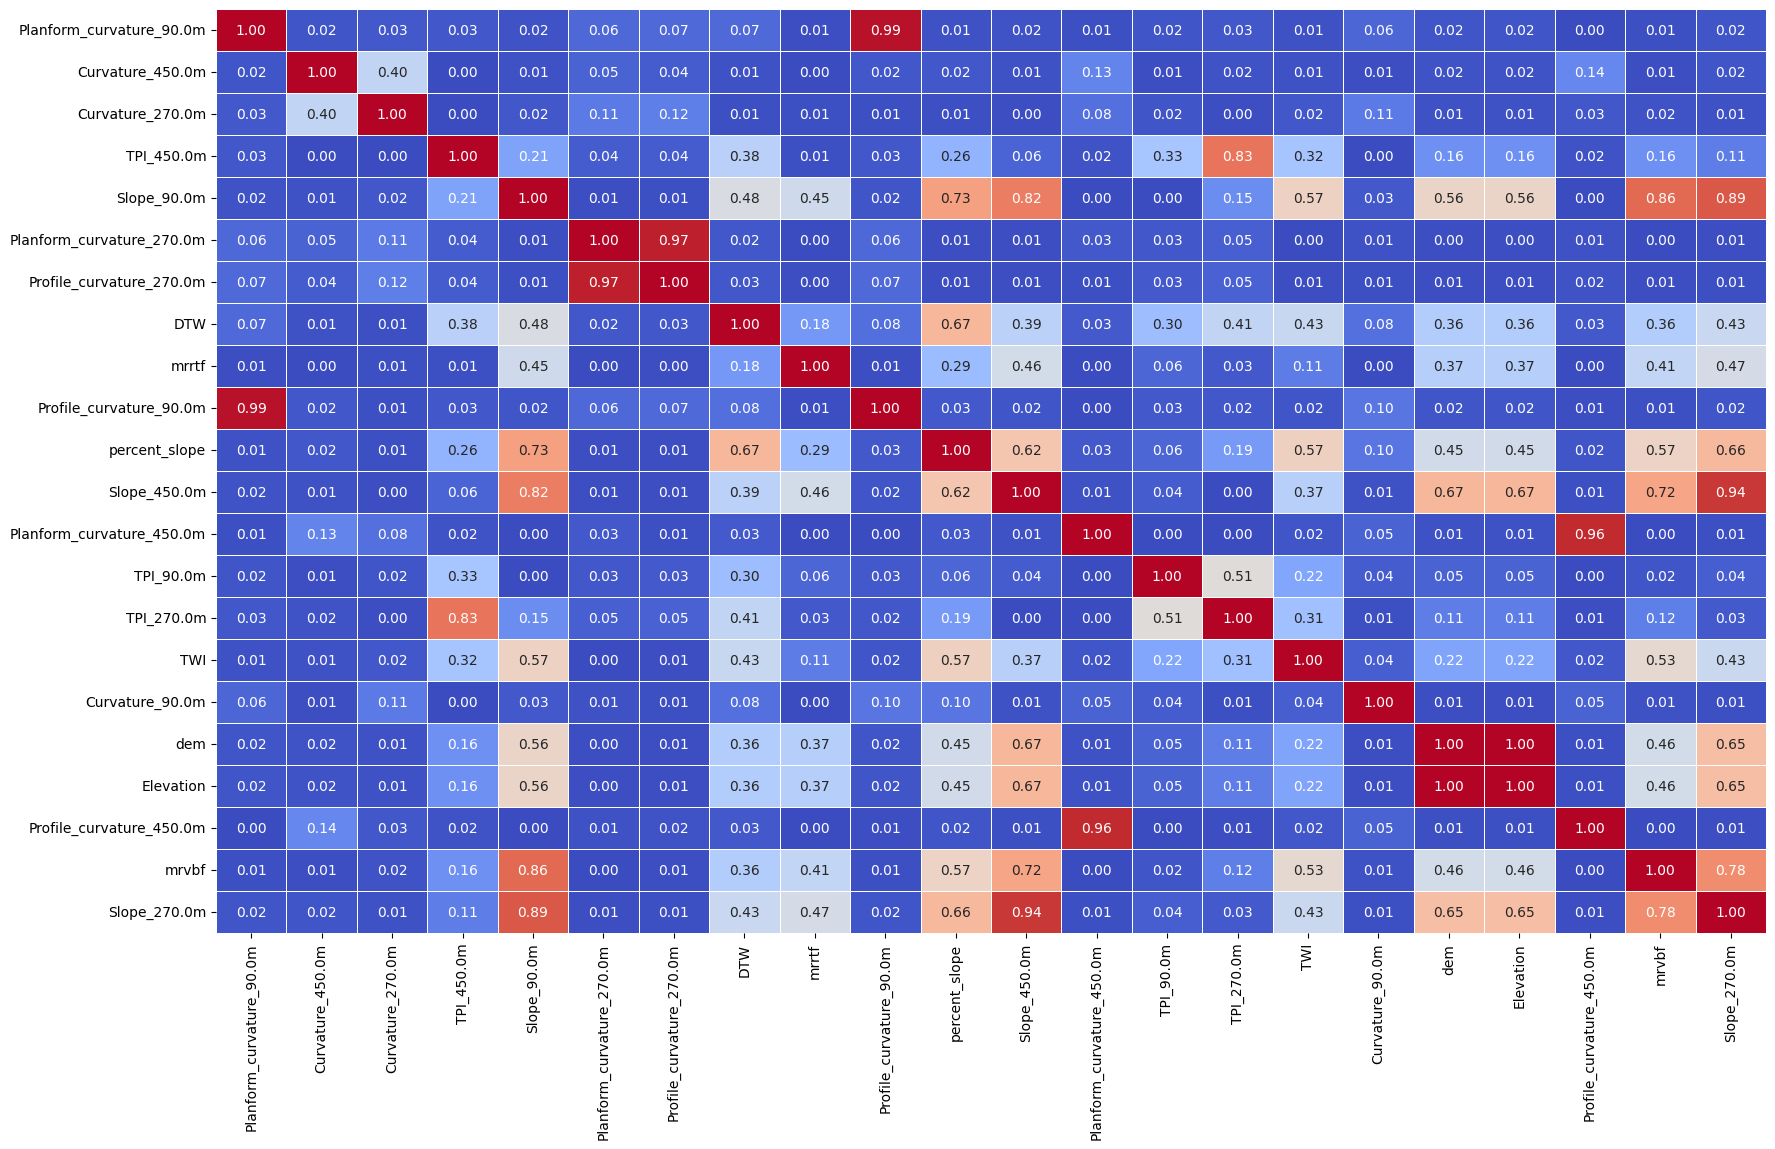

In [22]:
X_ = df_training_data.drop(fields, axis=1)

# Calculate the correlation matrix
correlation_matrix = X_.corr().abs()
# Create a heatmap without the colorbar
plt.figure(figsize=(20, 12))  # Adjust the figure size if needed
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar=False,
)
plt.show()

### Remove correlated features.
We will define a function and set a threshold of 0.8 to remove correlated features.

In [23]:
removal_threshold = 0.8

# function for removing correlated variables
def DropCorrelatedFeatures(X_, removal_threshold=0.9):
    to_drop = set()  # set of features to drop
    correlation_matrix = X_.corr().abs()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if (correlation_matrix.iloc[i, j] >= removal_threshold) and (correlation_matrix.columns[j] not in to_drop):
                colname = correlation_matrix.columns[i]
                to_drop.add(colname)
    to_drop = list(to_drop)
    print(f"{len(to_drop)} training features dropped: {to_drop}")
    X_dropped = X_.copy()
    X_dropped = X_dropped.drop(to_drop, axis=1)
    return X_dropped

# drop the class_id field
X_ = df_training_data.drop(fields[0], axis=1)
X_dropped = DropCorrelatedFeatures(X_, removal_threshold=removal_threshold)
df_training_data = pd.concat([df_training_data[fields[0]], X_dropped], axis = 1)

print(f"{len(X_dropped.columns)} training features kept")

8 training features dropped: ['Slope_450.0m', 'mrvbf', 'Profile_curvature_450.0m', 'Profile_curvature_270.0m', 'Profile_curvature_90.0m', 'TPI_270.0m', 'Slope_270.0m', 'Elevation']
15 training features kept


## Grid search for optimal hyperparameters

A number of hyperparameters can be tuned to optimize the performance of a random forest algorithm. These parameters specifiy how many decision trees are used, when and how data are split into nodes, how many samples and features are used when looking for the best split, and so on. A complete list of parameters and their explanations can be found in the [library documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier).

In our example, we perform a grid search of the following four hyperparameters:

* `class_weight`: Weights associated with classes. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.
* `max_features`: The number of features to consider when looking for the best split. If “sqrt”, then `max_features=sqrt(n_features)`. If “log2”, then `max_features=log2(n_features)`. If None, then `max_features=n_features`.
* `n_estimators`: The number of trees in the forest.
* `criterion`: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain, see [Mathematical formulation](https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation).

> Searching over a large grid takes time. For testing, the search can be applied on a subset of parameter options.

In [24]:
# Create the parameter grid based on the results of random search
grid_parameters = {
    "n_estimators": [int(x) for x in np.linspace(start=50, stop=100, num=2)],
    "max_features": ["sqrt", "log2"],
}

#### Binary classsifier
The provided code initializes a Random Forest classifier for binary classification, aiming to differentiate between wetland and non-wetland instances. It starts by preparing the feature matrix (X) and the corresponding binary labels (y_binary). Hyperparameter tuning is conducted using grid search and stratified K-fold cross-validation, seeking the optimal combination of parameters like the number of estimators and the maximum number of features. Once the best parameters are determined, the binary classifier is trained with these settings. This process ensures that the classifier is effectively trained to discern wetland areas from non-wetland ones based on the provided features.

In [25]:
# initialise a random forest classifier
rf = RandomForestClassifier()
# convert variable names into sci-kit learn nomenclature
X = df_training_data.to_numpy()[:, 2:]

y_binary = df_training_data[fields[0]].to_numpy()


# Create the parameter grid based on the results of random search
binary_grid_parameters = {
    "n_estimators": [int(x) for x in np.linspace(start=50, stop=100, num=2)],
    "max_features": ["sqrt", "log2"],
}

# stratified K-fold splitting strategy for grid search
cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# grid search to find optimal random forest classifier hyperparameters
print("Grid searching best hyper-parameters for binary classification...")
binary_grid_search = model_selection.GridSearchCV(
    estimator=rf, param_grid=binary_grid_parameters, cv=cv, n_jobs=-1
)

binary_grid_search.fit(X, y_binary)
print(
    "Optimal parameters for binary classification: \n", binary_grid_search.best_params_
)

# Train the binary classifier with the best parameters
binary_rf = RandomForestClassifier(
    **binary_grid_search.best_params_, random_state=1, n_jobs=-1
)
binary_rf.fit(X, y_binary)

Grid searching best hyper-parameters for binary classification...
Optimal parameters for binary classification: 
 {'max_features': 'sqrt', 'n_estimators': 100}


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Wetland types classifier
Similar to the binary classifier, we define a parameter grid for hyperparameter tuning of the wetland type classifier. Then we perform grid search to find the optimal hyperparameters for the wetland type classifier using GridSearchCV. After finding the optimal parameters, we train the wetland type classifier (type_rf) using these parameters and the filtered feature matrix and target variable.

In [26]:
# Filter out only the wetland points for type classification
wetland_indices = np.where(y_binary)[0]
X_wetland = X[wetland_indices]

# Check if the second field is available in the fields variable
if len(fields) > 1:
    y_wetland_type = df_training_data[fields[1]].to_numpy()[wetland_indices]
else:
    print("No wetland classes available.")
    # Handle the absence of wetland classes (skip further processing or raise an exception)

# Remove instances labeled as non-wetland from wetland type classification
if "y_wetland_type" in locals():
    non_wetland_indices = np.where(y_wetland_type != 0)[0]
    X_wetland = X_wetland[non_wetland_indices]
    y_wetland_type = y_wetland_type[non_wetland_indices]

    # Define parameter grid for wetland type classification
    type_grid_parameters = {
        "n_estimators": [int(x) for x in np.linspace(start=50, stop=100, num=2)],
        "max_features": ["sqrt", "log2"],
    }

    # Grid search to find optimal hyperparameters for wetland type classification
    print("Grid searching best hyper-parameters for wetland type classification...")
    type_grid_search = model_selection.GridSearchCV(
        estimator=rf, param_grid=type_grid_parameters, cv=cv, n_jobs=-1
    )
    type_grid_search.fit(X_wetland, y_wetland_type)
    print(
        "Optimal parameters for wetland type classification: \n",
        type_grid_search.best_params_,
    )

    # Train the wetland type classifier with the best parameters
    type_rf = RandomForestClassifier(
        **type_grid_search.best_params_, random_state=1, n_jobs=-1
    )
    type_rf.fit(X_wetland, y_wetland_type)

Grid searching best hyper-parameters for wetland type classification...
Optimal parameters for wetland type classification: 
 {'max_features': 'sqrt', 'n_estimators': 100}


### Examine feature importance

Feature importance shows which features have the largest effect on the model prediction. We will explore the top 10 most important features and visualize the importance of all features.

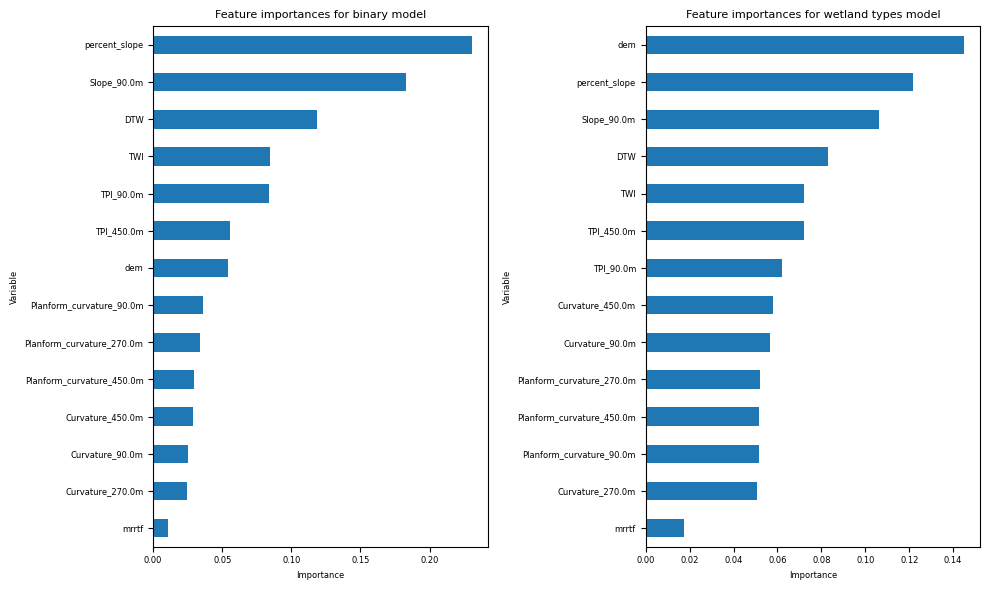

In [27]:
binary_feature_importances = binary_rf.feature_importances_

# List of variable names
variable_names = df_training_data.columns[2:]

# Calculate the figure width based on the number of variables
figure_width = max(5, len(variable_names) * 0.1)  # Minimum width of 8 inches

# If type_rf is available, create subplots for binary and type classifications
if "type_rf" in locals():
    # Create subplots for binary classification and wetland type classification side by side
    fig, axs = plt.subplots(1, 2, figsize=(2 * figure_width, 6))

    # Plot feature importances for binary classification
    order_binary = np.argsort(binary_feature_importances)[::-1]
    order_binary = order_binary[
        ::-1
    ]  # Reverse order to display most important variables at the top
    axs[0].barh(
        y=variable_names[order_binary],
        width=binary_feature_importances[order_binary],
        height=0.5,
        align="center",
    )
    axs[0].set_title("Feature importances for binary model", fontsize=8)
    axs[0].set_ylabel("Variable", fontsize=6)
    axs[0].tick_params(axis="both", which="major", labelsize=6)
    axs[0].set_xlabel("Importance", fontsize=6)
    axs[0].set_ylim(-0.5, len(variable_names) - 0.5)

    type_feature_importances = type_rf.feature_importances_
    # Plot feature importances for wetland type classification
    order_type = np.argsort(type_feature_importances)[::-1]
    order_type = order_type[
        ::-1
    ]  # Reverse order to display most important variables at the top
    axs[1].barh(
        y=variable_names[order_type],
        width=type_feature_importances[order_type],
        height=0.5,
        align="center",
    )
    axs[1].set_title("Feature importances for wetland types model", fontsize=8)
    axs[1].set_ylabel("Variable", fontsize=6)
    axs[1].tick_params(axis="both", which="major", labelsize=6)
    axs[1].set_xlabel("Importance", fontsize=6)
    axs[1].set_ylim(-0.5, len(variable_names) - 0.5)

    plt.tight_layout()  # Automatically adjust the layout
    plt.show()
else:
    # If type_rf is not available, plot only the feature importances for binary classification
    plt.figure(figsize=(figure_width, 6))
    order_binary = np.argsort(binary_feature_importances)[::-1]
    order_binary = order_binary[
        ::-1
    ]  # Reverse order to display most important variables at the top
    plt.barh(
        y=variable_names[order_binary],
        width=binary_feature_importances[order_binary],
        height=0.5,
        align="center",
    )
    plt.title("Feature importances for binary model", fontsize=8)
    plt.ylabel("Variable", fontsize=6)
    plt.tick_params(axis="both", which="major", labelsize=6)
    plt.xlabel("Importance", fontsize=6)
    plt.ylim(-0.5, len(variable_names) - 0.5)
    plt.tight_layout()  # Automatically adjust the layout
    plt.show()

## Accuracy assessment

Finally we use a 5-fold cross validation to estimate the performance of the model. While the cross validation evaluates the predictive power of our model on unseen data, the result may not generalize for input data that have distinct spectral and temporal signatures to the training dataset. 

We will inspect four performance metrics:

* Overall accuracy
* Precision for each class - fraction of positive predictions that are correct. $precision = N_{True Positive}/(N_{True Positive} + N_{False Positive})$. The best value is 1 and the worst value is 0.
* Recall for each class - ability of the classifier to find all the positive samples. $recall = N_{True Positive}/(N_{True Positive} + N_{False Negative})$. The best value is 1 and the worst value is 0.
* F1 macro - averaged F1 scores for all classes. For each class, $F1 = 2*(precision*recall)/(precision+recall)$
* Plot confusion matrix - The confusion matrix compares all predictions against the labels and allow us to see what types of prediction errors the model is making. 


Binary Classification Evaluation:
Overall accuracy from cross-validation (Binary):  0.88925
Precision for each class (Binary): 
 {'Non-wetland': 0.904, 'Wetland': 0.867}
Recall for each class (Binary): 
 {'Non-wetland': 0.913, 'Wetland': 0.853}
F1_macro from cross-validation scores (Binary):  0.8841546846913442
Confusion matrix (Binary):



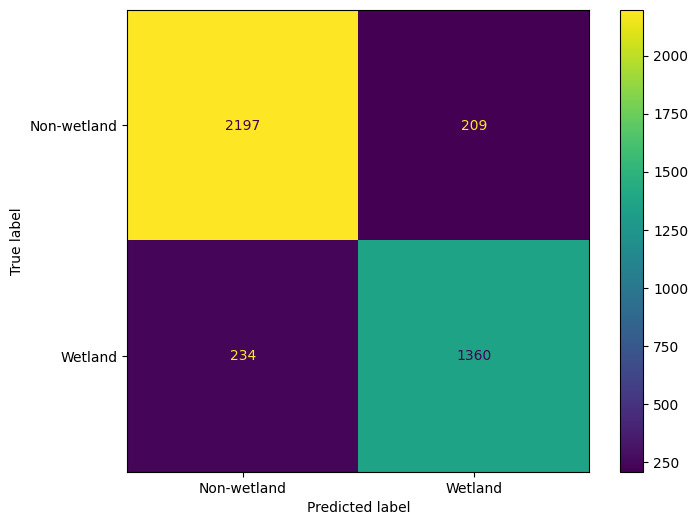


Wetland Type Classification Evaluation:
Overall accuracy from cross-validation (Wetland Type):  0.6461781116302913
Precision for each class (Wetland Type): 
 {'Freshwater Pond': 0.568, 'Lake': 0.813, 'Freshwater Forested/Shrub Wetland': 0.585, 'Riverine': 0.658, 'Freshwater Emergent Wetland': 0.598}
Recall for each class (Wetland Type): 
 {'Freshwater Pond': 0.414, 'Lake': 0.825, 'Freshwater Forested/Shrub Wetland': 0.754, 'Riverine': 0.715, 'Freshwater Emergent Wetland': 0.239}
F1_macro from cross-validation scores (Wetland Type):  0.5959195789407342
Confusion matrix (Wetland Type):



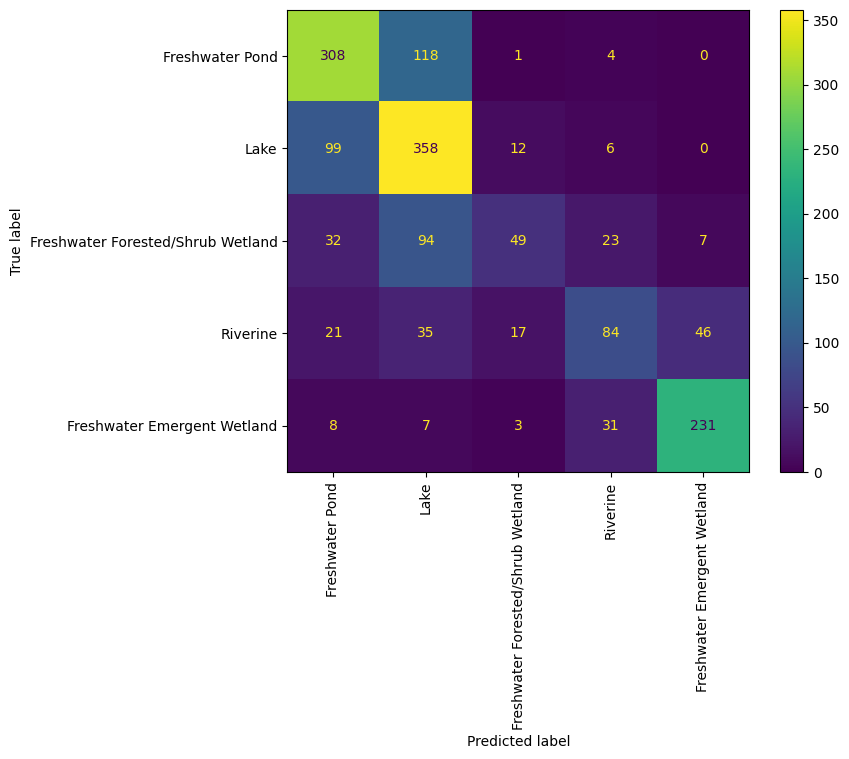

In [28]:
# Import the class label dictionary for wetland types
with open(f"/data/{prefix}_labels_dict.json", "r") as json_file:
    labels_dict_type = json.load(json_file)

# Remove the non-wetland class from the dictionary
if 0 in labels_dict_type.values():
    del labels_dict_type["Non-wetland"]

# Create a new label dictionary for binary classification
labels_dict_binary = {"Non-wetland": 0, "Wetland": 1}

# Stratified k-fold splitting
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Binary classification evaluation
print("Binary Classification Evaluation:")
overall_acc_binary = model_selection.cross_val_score(
    binary_rf, X, y_binary, cv=skf, scoring="accuracy"
)
print("Overall accuracy from cross-validation (Binary): ", np.mean(overall_acc_binary))

predictions_binary = model_selection.cross_val_predict(binary_rf, X, y_binary, cv=skf)
precision_binary = precision_score(
    y_binary, predictions_binary, labels=list(labels_dict_binary.values()), average=None
)
print(
    "Precision for each class (Binary): \n",
    dict(zip(list(labels_dict_binary.keys()), np.around(precision_binary, 3))),
)

recall_binary = recall_score(
    y_binary, predictions_binary, labels=list(labels_dict_binary.values()), average=None
)
print(
    "Recall for each class (Binary): \n",
    dict(zip(list(labels_dict_binary.keys()), np.around(recall_binary, 3))),
)

f1_macro_binary = model_selection.cross_val_score(
    binary_rf, X, y_binary, cv=skf, scoring="f1_macro"
)
print("F1_macro from cross-validation scores (Binary): ", np.mean(f1_macro_binary))

cm_binary = confusion_matrix(y_binary, predictions_binary)
disp_binary = ConfusionMatrixDisplay(
    confusion_matrix=cm_binary, display_labels=list(labels_dict_binary.keys())
)
print("Confusion matrix (Binary):\n")
fig_binary, ax_binary = plt.subplots(figsize=(8, 6))
disp_binary.plot(ax=ax_binary)
plt.show()


# Define the file paths for saving the feature names
binary_features_path = f"/data/results/{prefix}_binary_model_features.json"
# Create dictionaries to store the feature names
binary_features_dict = {}
# Store binary model feature names
binary_features_dict["features"] = list(variable_names)
# Save the binary model feature names to a JSON file
with open(binary_features_path, "w") as binary_file:
    json.dump(binary_features_dict, binary_file, indent=4)

# Save the binary classification model
dump(binary_rf, f"/data/results/{prefix}_Binary_RF_model.joblib")

# Wetland type classification evaluation if type_rf exists
if "type_rf" in locals():
    print("\nWetland Type Classification Evaluation:")
    overall_acc_type = model_selection.cross_val_score(
        type_rf, X_wetland, y_wetland_type, cv=skf, scoring="accuracy"
    )
    print(
        "Overall accuracy from cross-validation (Wetland Type): ",
        np.mean(overall_acc_type),
    )

    predictions_type = model_selection.cross_val_predict(
        type_rf, X_wetland, y_wetland_type, cv=skf
    )
    precision_type = precision_score(
        y_wetland_type,
        predictions_type,
        labels=list(labels_dict_type.values()),
        average=None,
    )
    print(
        "Precision for each class (Wetland Type): \n",
        dict(zip(list(labels_dict_type.keys()), np.around(precision_type, 3))),
    )

    recall_type = recall_score(
        y_wetland_type,
        predictions_type,
        labels=list(labels_dict_type.values()),
        average=None,
    )
    print(
        "Recall for each class (Wetland Type): \n",
        dict(zip(list(labels_dict_type.keys()), np.around(recall_type, 3))),
    )

    f1_macro_type = model_selection.cross_val_score(
        type_rf, X_wetland, y_wetland_type, cv=skf, scoring="f1_macro"
    )
    print(
        "F1_macro from cross-validation scores (Wetland Type): ", np.mean(f1_macro_type)
    )

    # Filter labels_dict_type to include only classes present in unique_classes
    unique_classes = np.unique(predictions_type)
    filtered_labels_dict_type = {
        label: labels_dict_type[label]
        for label in labels_dict_type
        if labels_dict_type[label] in unique_classes
    }
    # Update the display_labels accordingly
    display_labels = list(filtered_labels_dict_type.keys())

    # plot the confusion matrix with the correct number of labels
    cm_type = confusion_matrix(y_wetland_type, predictions_type)
    disp_type = ConfusionMatrixDisplay(
        confusion_matrix=cm_type, display_labels=display_labels
    )
    print("Confusion matrix (Wetland Type):\n")
    fig_type, ax_type = plt.subplots(figsize=(8, 6))
    disp_type.plot(ax=ax_type, xticks_rotation="vertical")
    plt.show()

    # Define the file paths for saving the feature names
    type_features_path = f"/data/results/{prefix}_type_model_features.json"
    # Create dictionaries to store the feature names
    type_features_dict = {}
    # Store type model feature names
    type_features_dict["features"] = list(variable_names)
    # Save the type model feature names to a JSON file
    with open(type_features_path, "w") as type_file:
        json.dump(type_features_dict, type_file, indent=4)

    # Save the wetland type classification model
    dump(type_rf, f"/data/results/{prefix}_Type_RF_model.joblib")

In [29]:
if os.path.exists(binary_features_path):
    with open(binary_features_path, "r") as binary_file:
        binary_features_dict = json.load(binary_file)
    binary_feature_names = binary_features_dict["features"]
    print(type(binary_feature_names))
    print("Loaded binary model features.")
else:
    print("No binary model features found.")

<class 'list'>
Loaded binary model features.


### Partial Dependece Plots 

Partial Dependence Plots (PDPs) are an important tool for understanding how each feature in a trained model influences its predictions. In this section, we use PDPs to interpret the behavior of our Random Forest models: binary_rf (for binary wetland classification) and type_rf (for classifying wetland types). 

**Binary Random Forest (binary_rf)**
For the binary classification task, PDPs will show the relationship between features and the probability of a positive prediction (e.g., wetland or non-wetland). These plots provide insights into how each feature contributes to the binary classification decision.

**Multi-Class Random Forest (type_rf)**
For the multi-class classification task, PDPs will be generated for each class (e.g., different wetland types). By specifying a target class, we can examine the effect of each feature on the probability of predicting that specific wetland type.
The shape of the curve indicates the relationship between the feature and the model’s prediction.

1. **Positive relationship:** If the plot rises as the feature value increases, this indicates a positive relationship between the feature and the target variable. The model sees higher values of this feature as more favorable (or associated with a higher likelihood of a certain prediction).
2. **Negative relationship:** If the plot falls as the feature value increases, this indicates a negative relationship between the feature and the target variable. The model sees lower values of this feature as more favorable (or associated with a higher likelihood of a certain prediction).
3. **No relationship**:If the plot is flat (horizontal line), this indicates that changes in the feature do not affect the model's prediction (i.e., there is no effect of that feature on the prediction).

#### Binary Random Forest PDPs

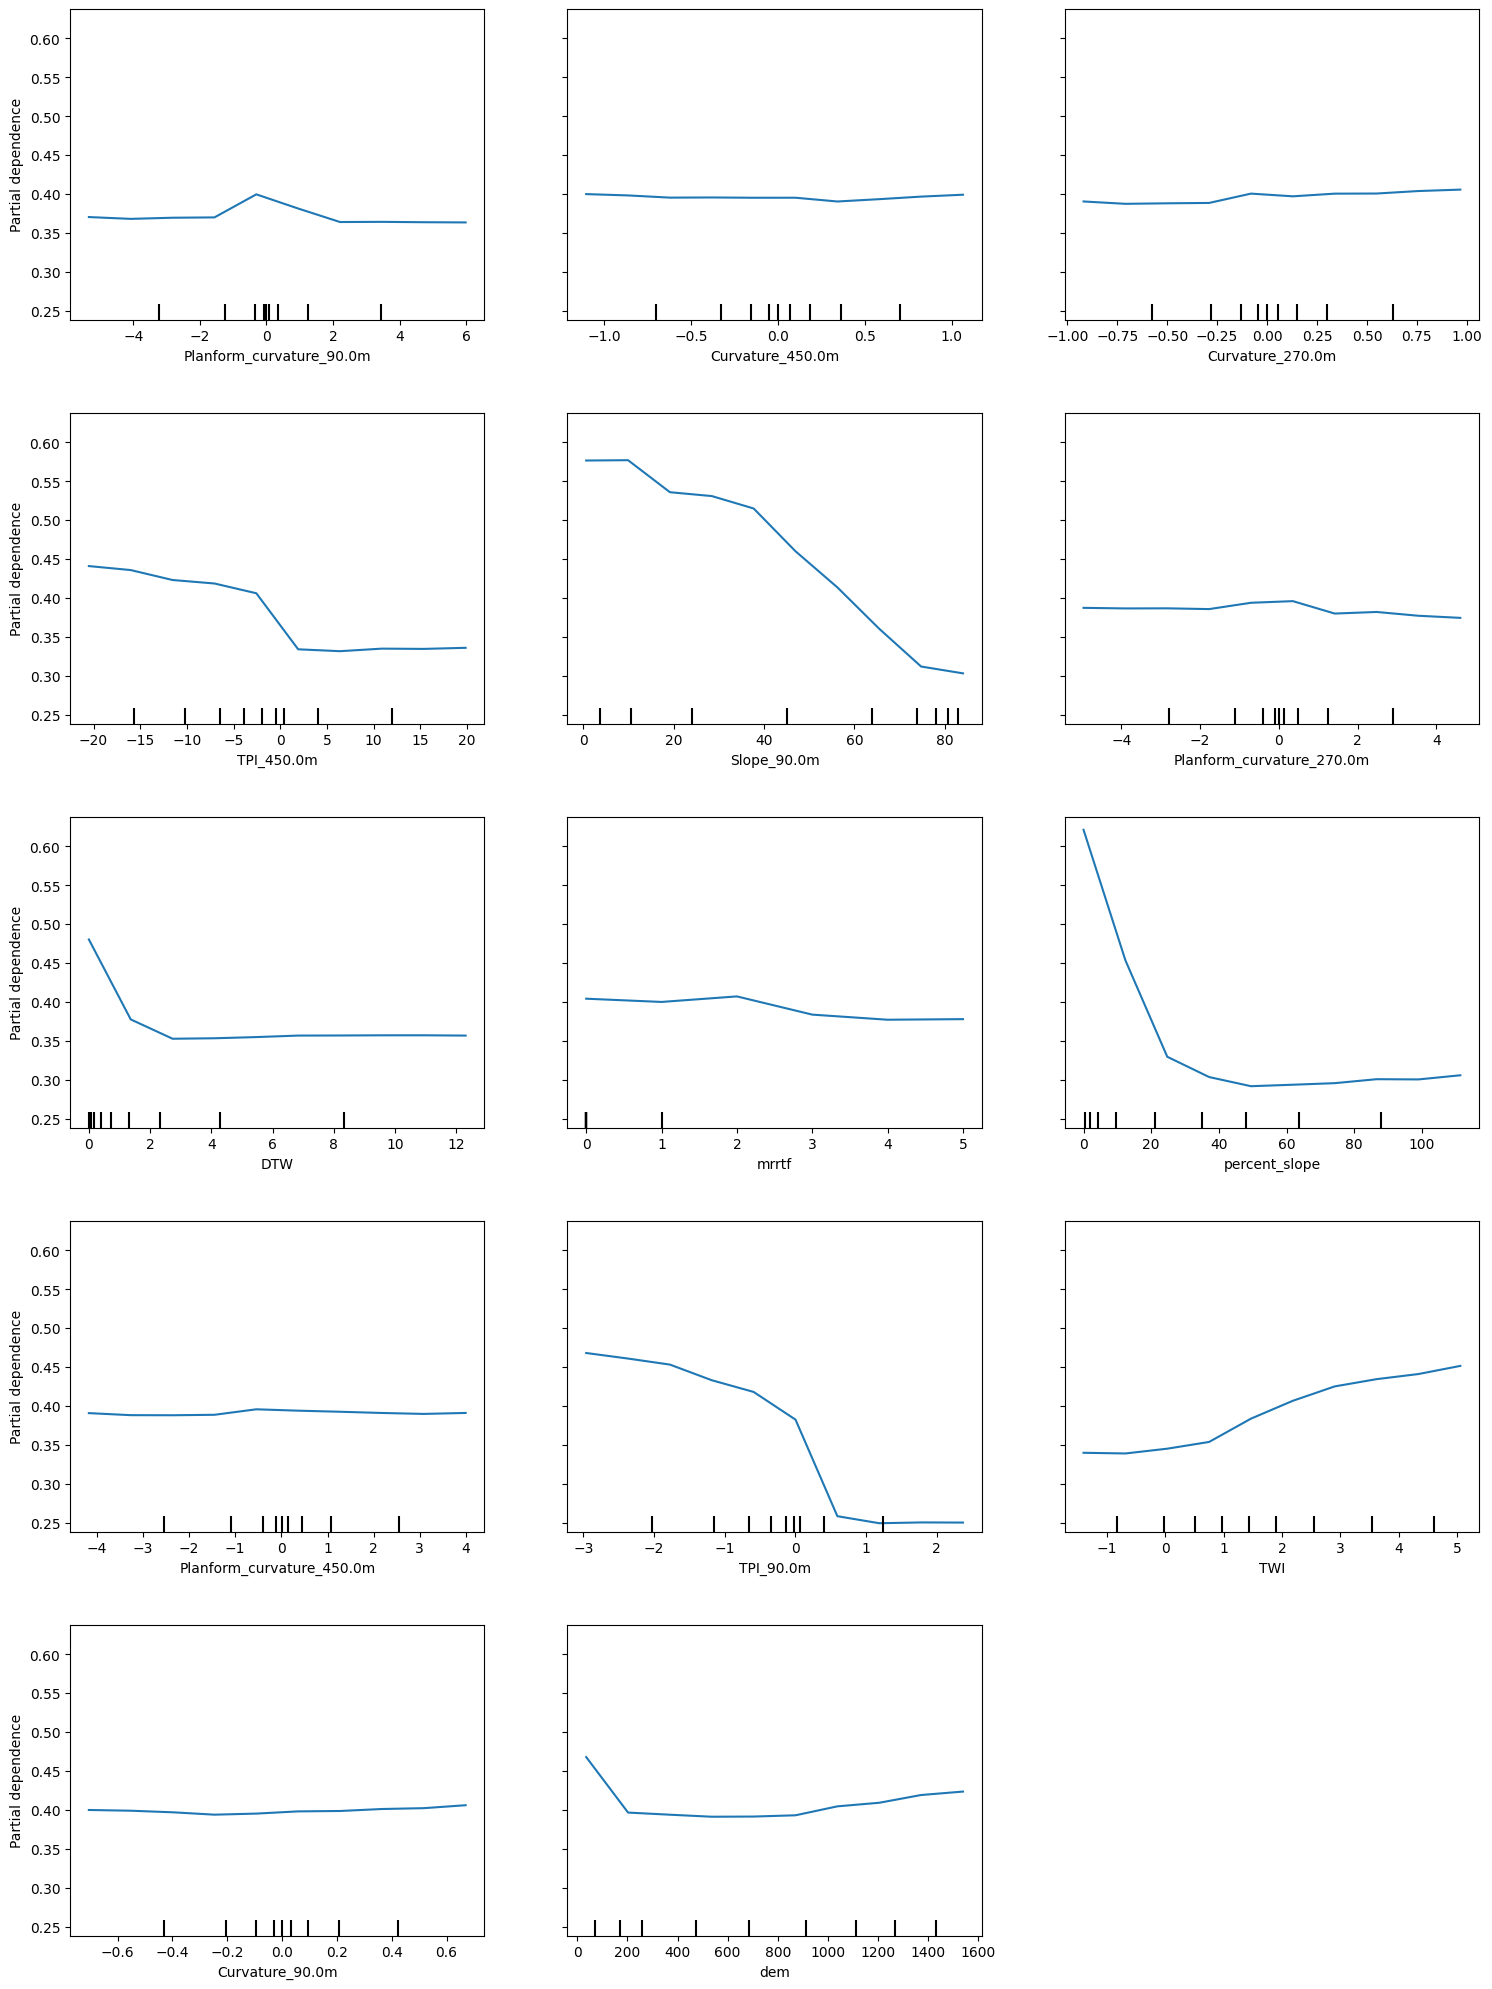

In [30]:
# Drop the first two columns and get the remaining feature names
feature_names = df_training_data.columns[2:].tolist()

# Create feature index mapping based on the actual feature names
features = [(i,) for i in range(len(feature_names))]

# Determine the number of rows dynamically (e.g., 5 features per row)
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols  # Ensures enough rows

# Increase height per row
fig, ax = plt.subplots(figsize=(15, 4 * n_rows))

# Only call from_estimator — it handles plotting internally
PartialDependenceDisplay.from_estimator(
    binary_rf,
    X,
    features=features,
    feature_names=feature_names,
    grid_resolution=10,
    ax=ax,
    n_cols=n_cols,
)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

#### Multi-Class Random Forest PDPs

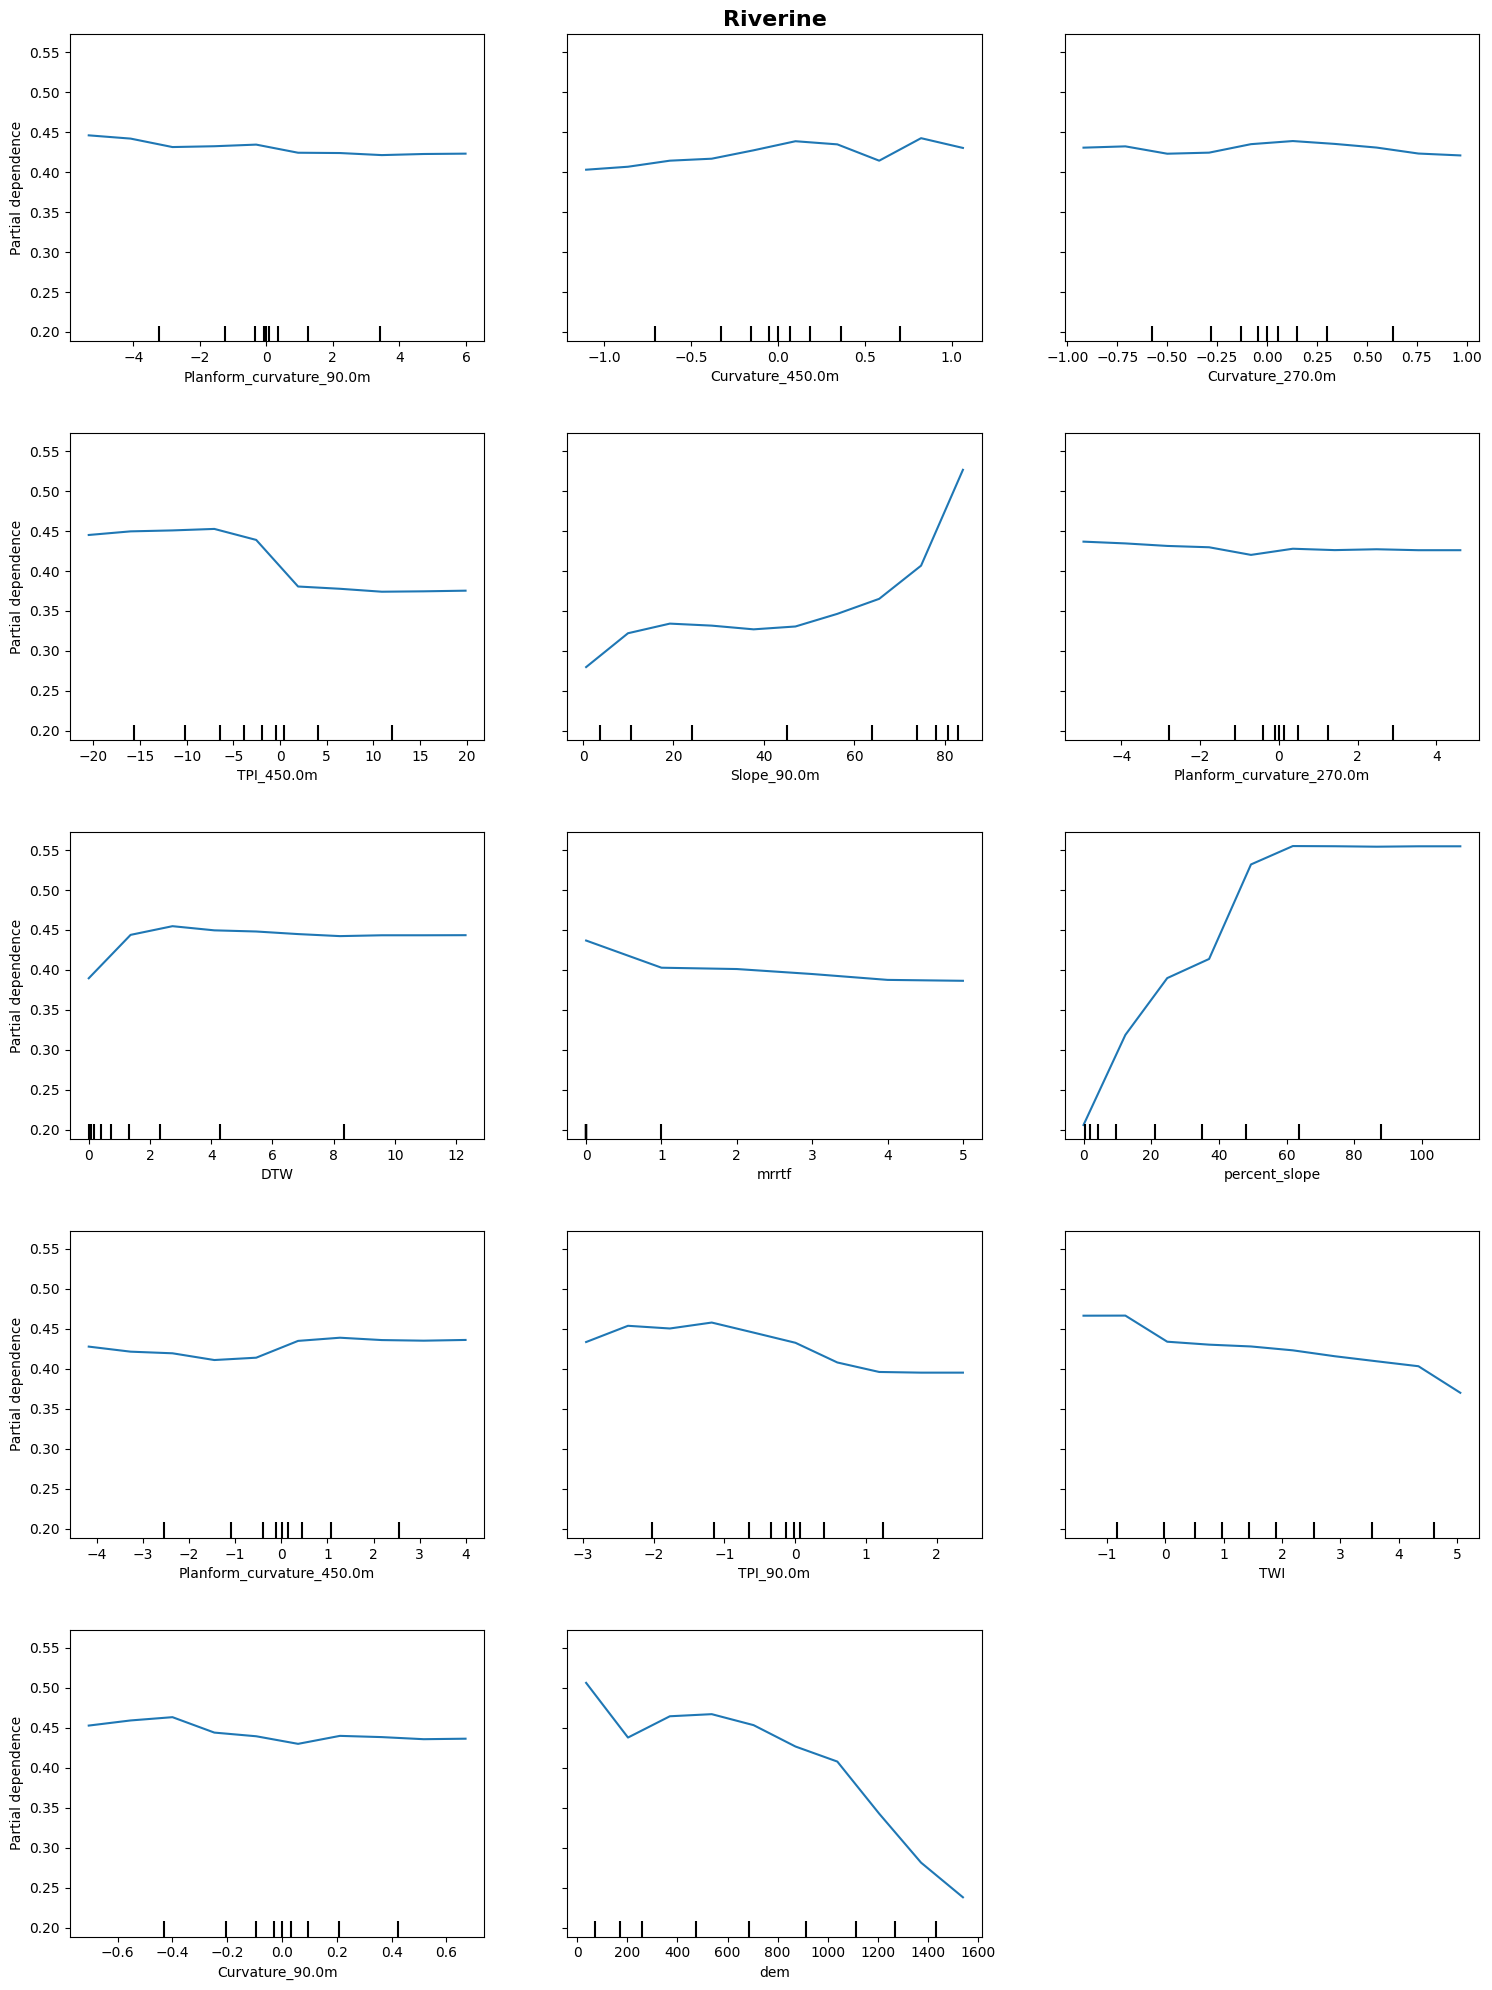

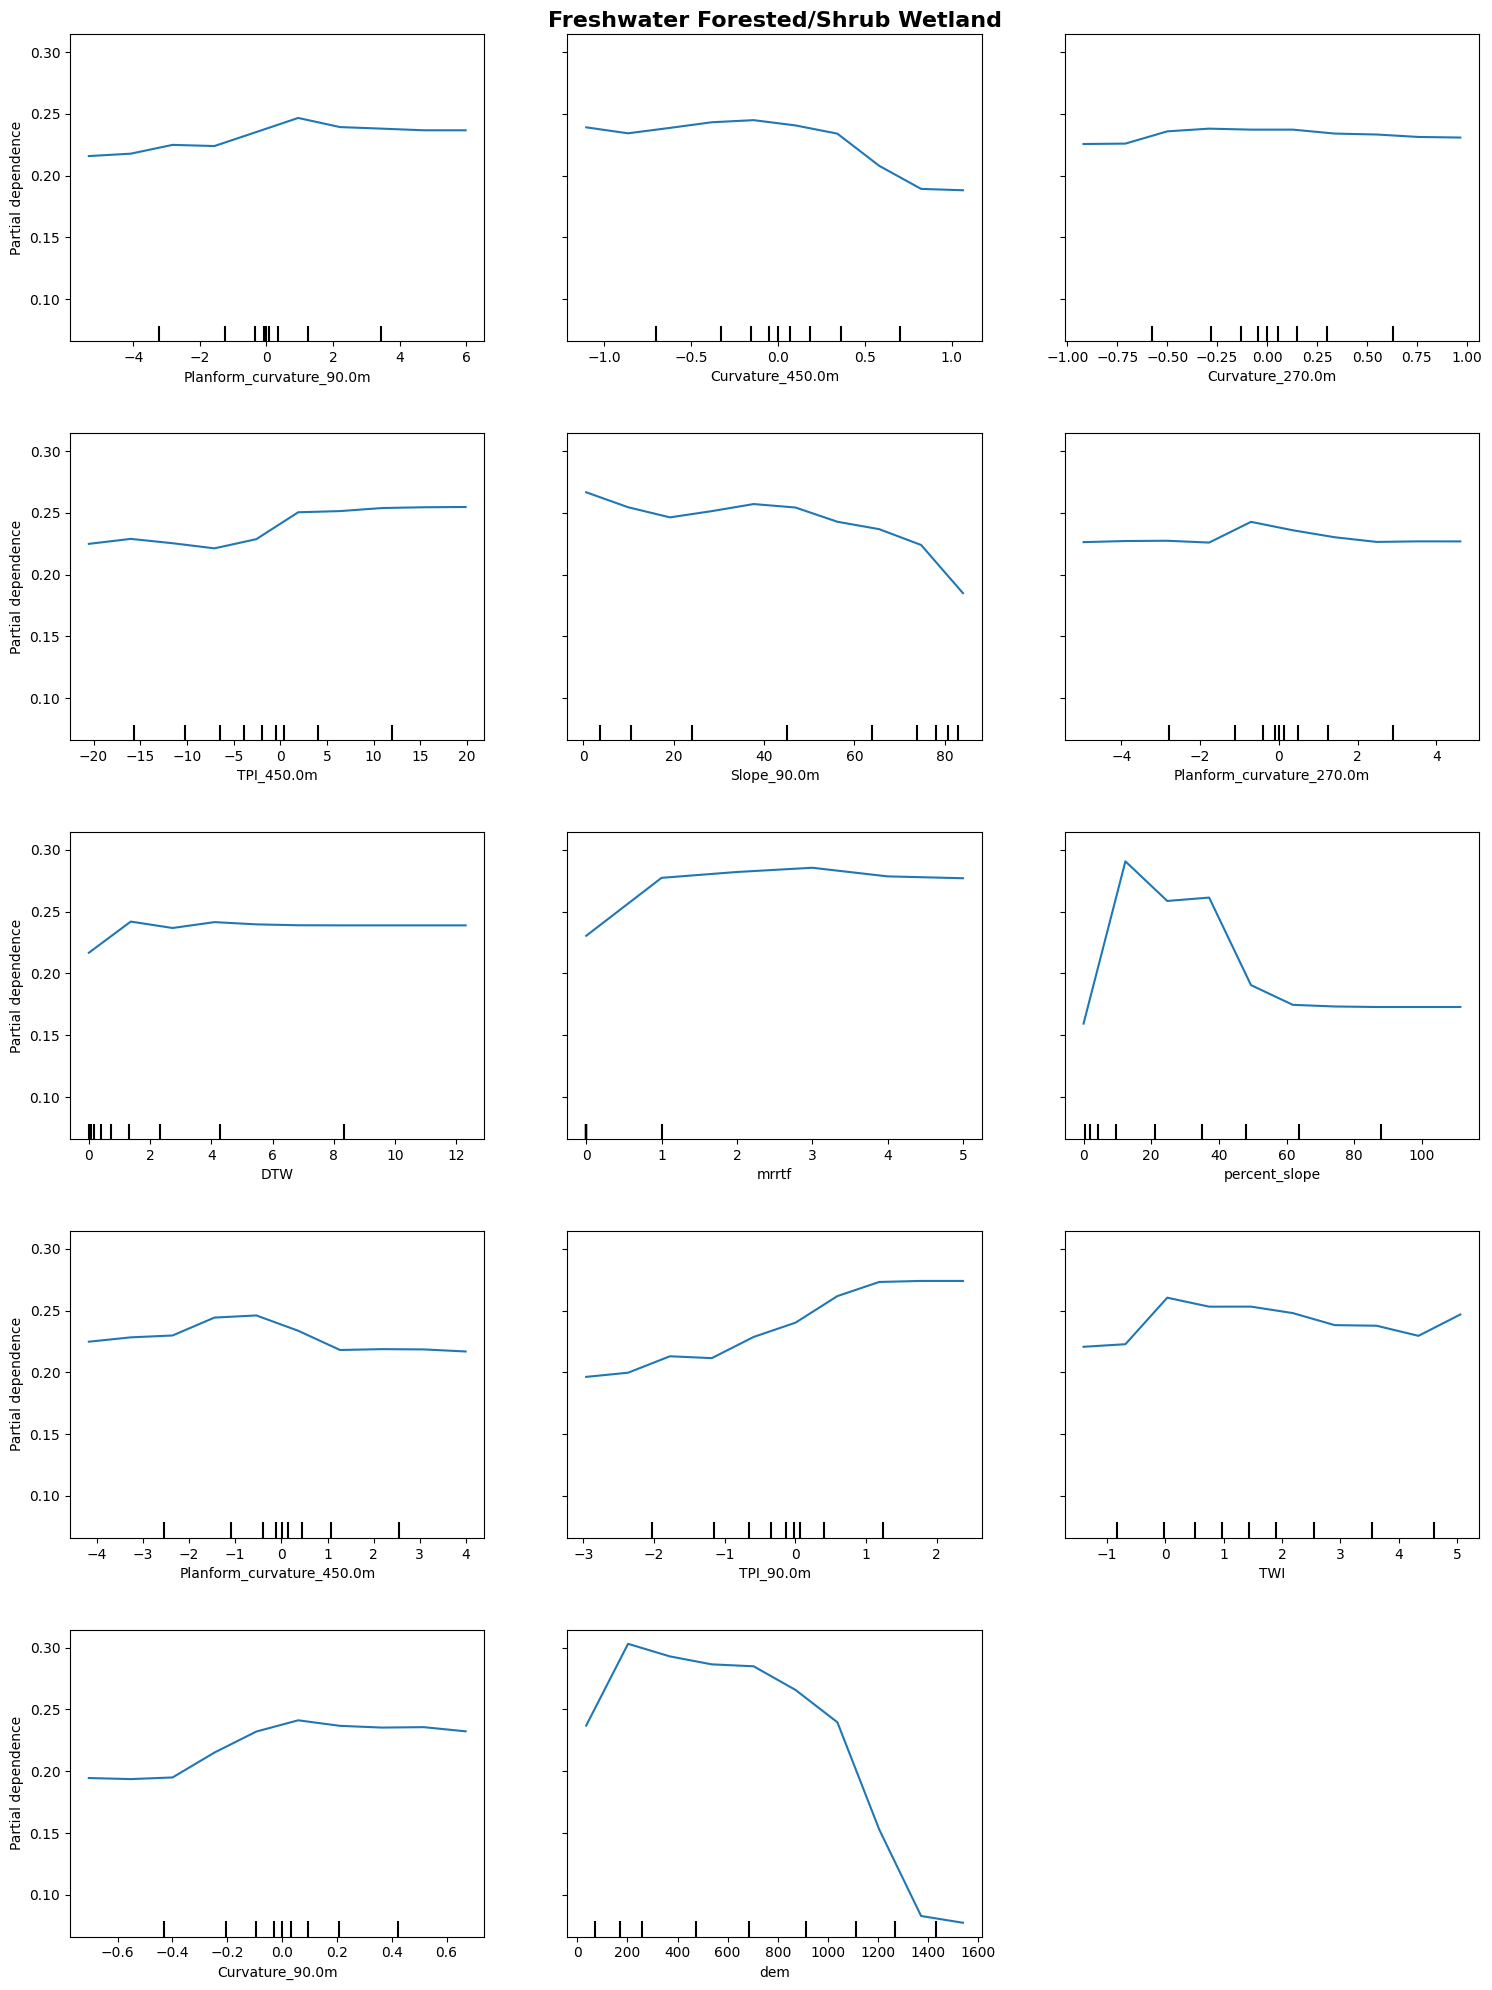

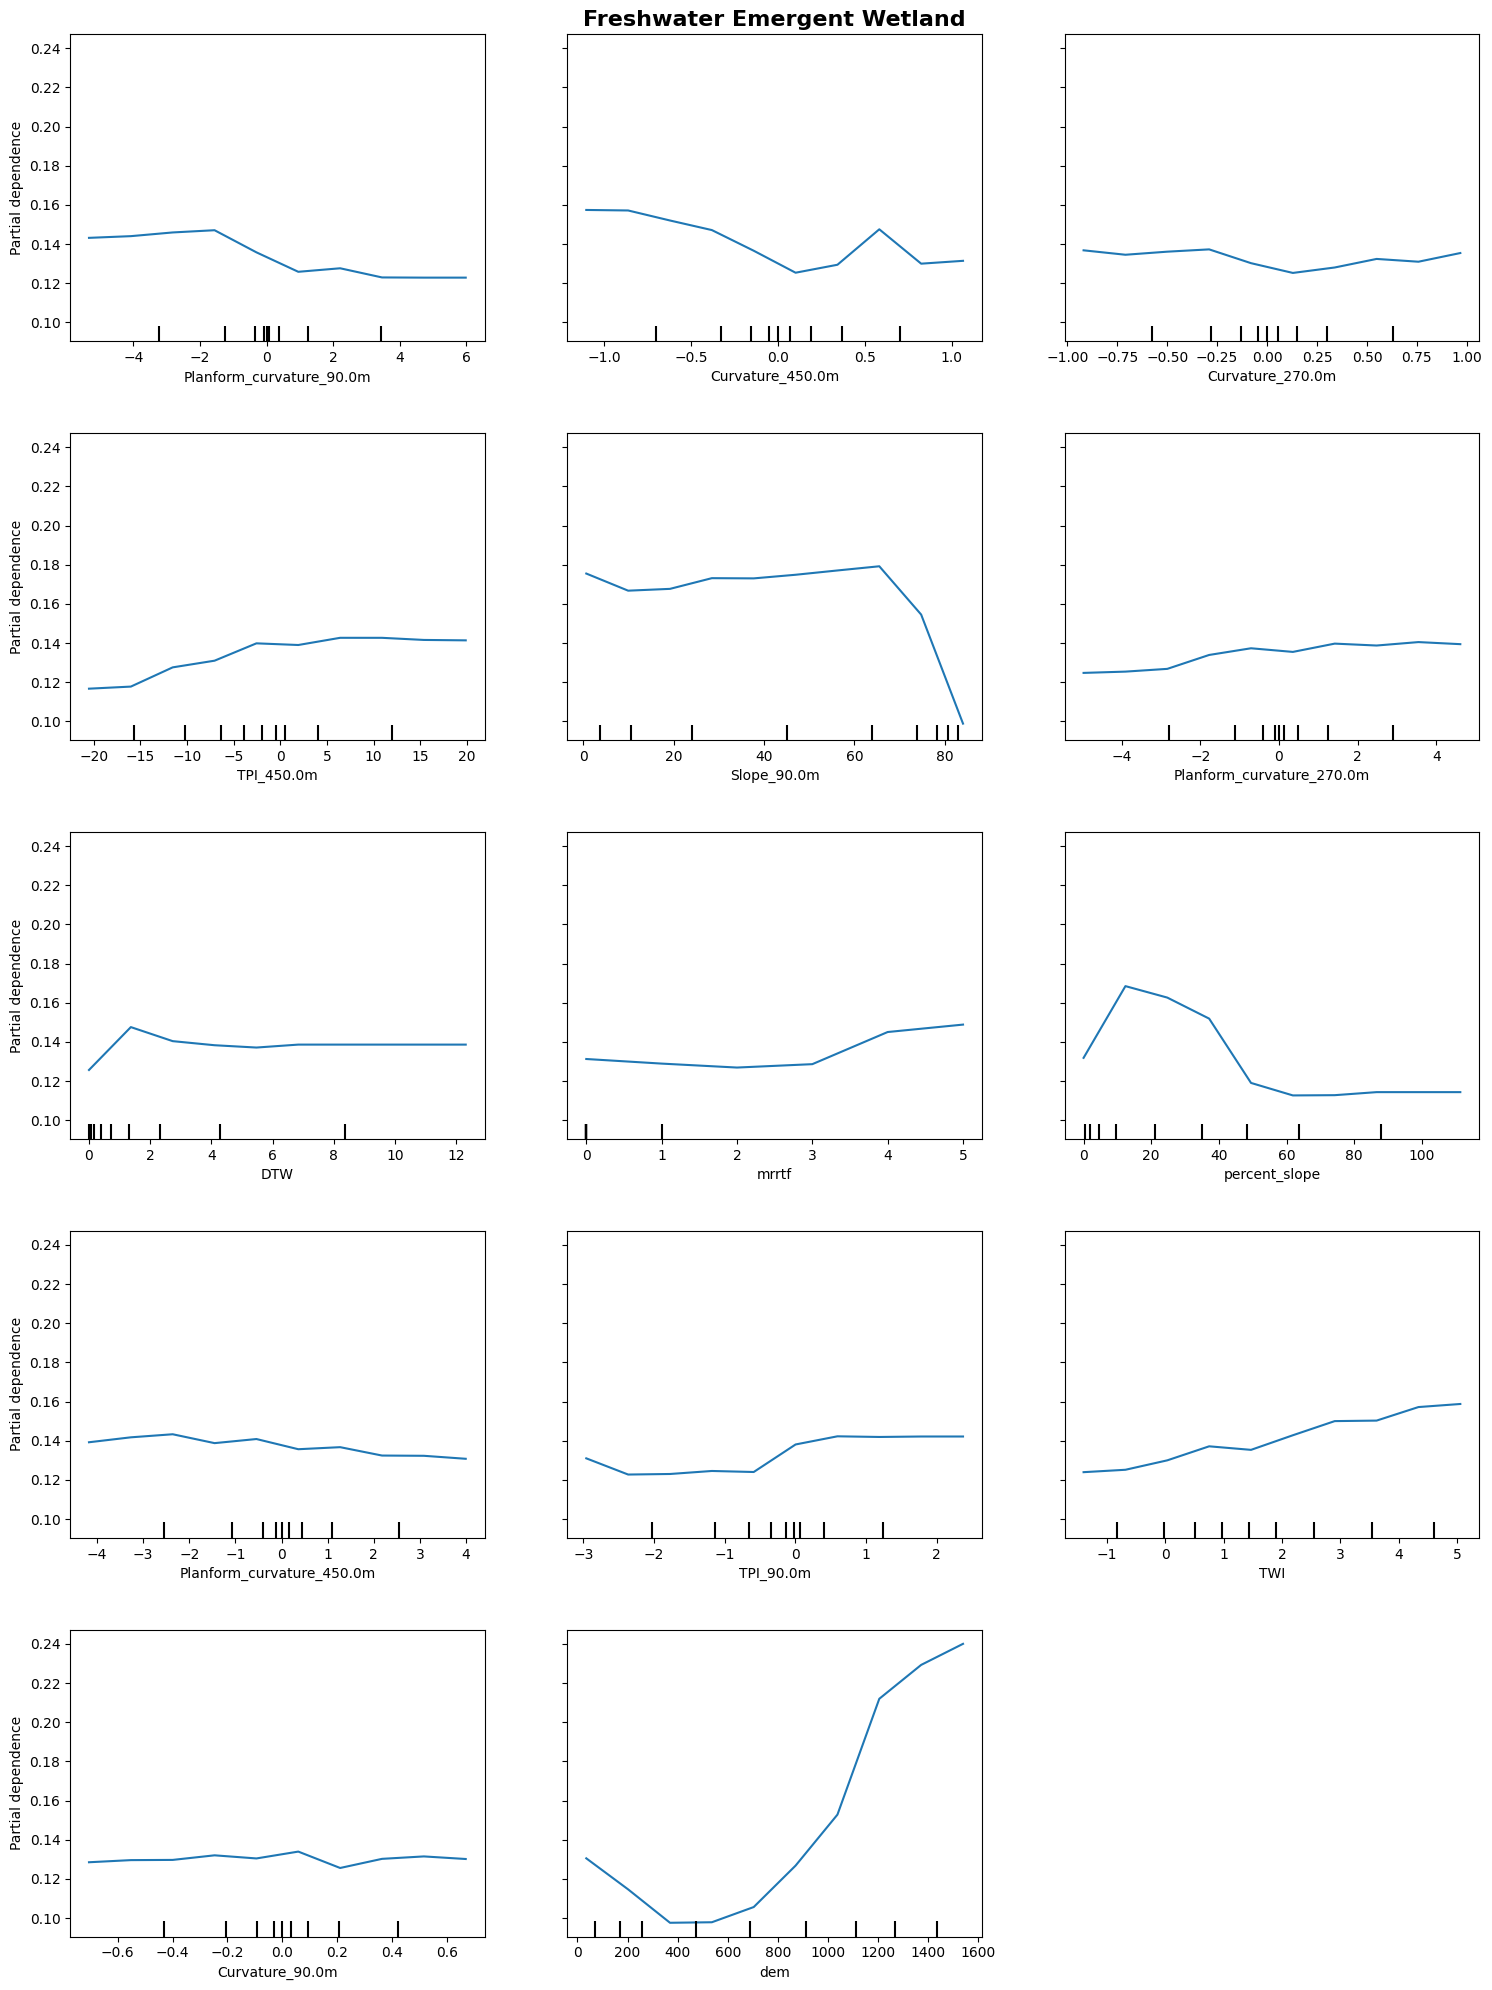

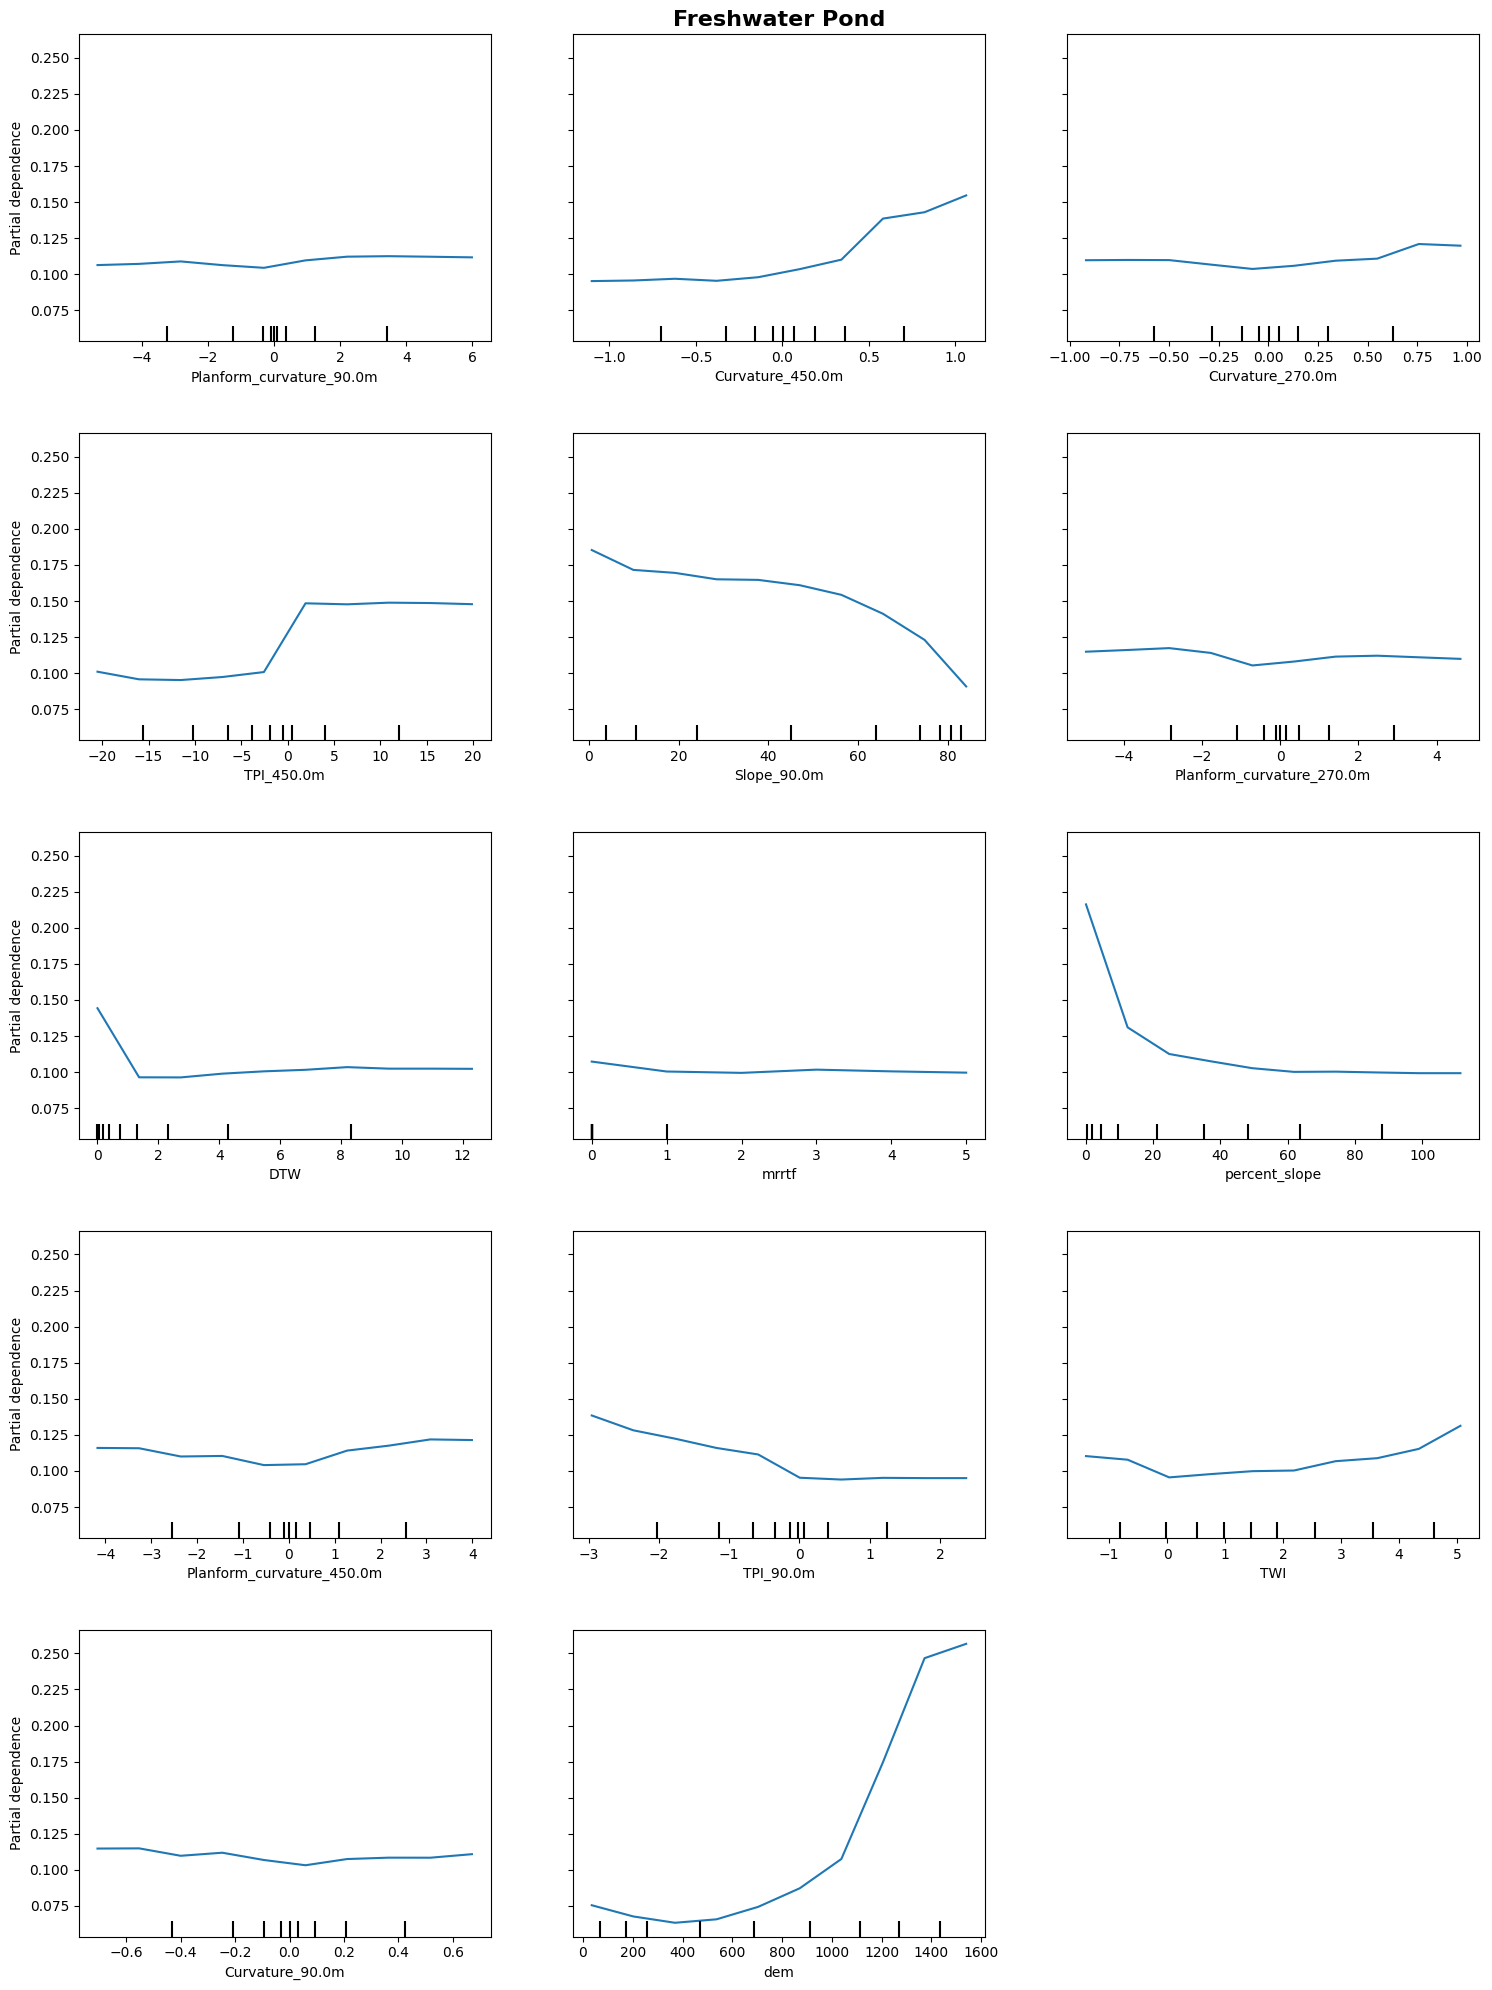

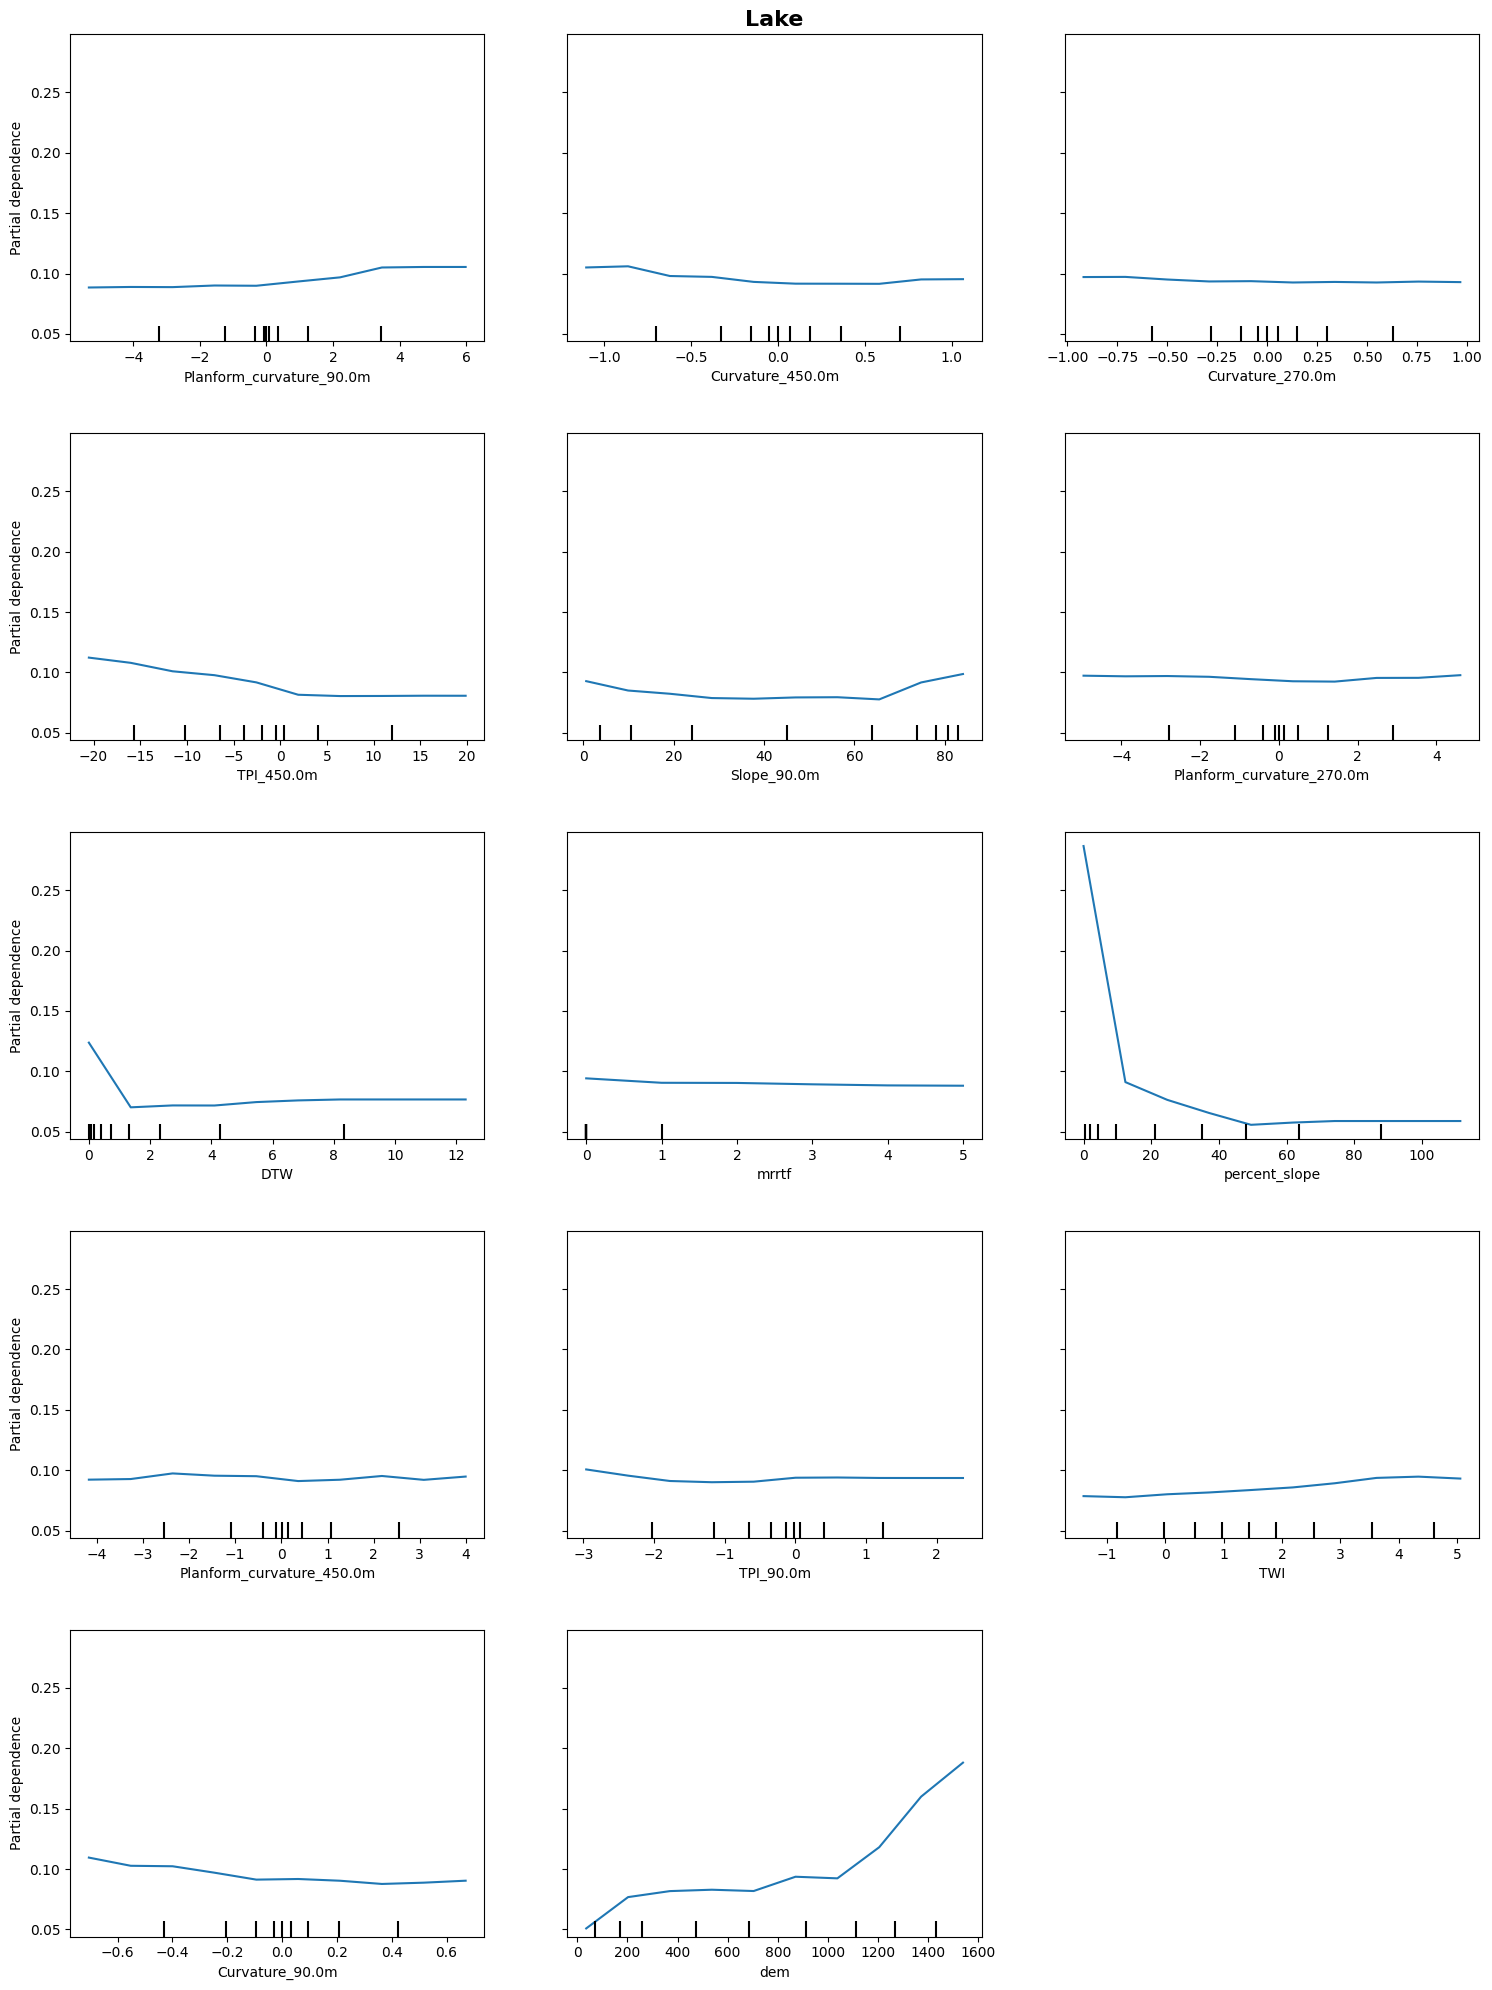

In [31]:
# Get the classes in the type_rf model
classes = type_rf.classes_

# Loop through each class and generate a PDP
for class_id in classes:
    # Map class_id to its name from the labels_dict_type
    class_name = [name for name, cid in labels_dict_type.items() if cid == class_id][0]

    # Determine the number of rows dynamically (e.g., 5 features per row)
    n_cols = 3
    n_rows = (len(features) + n_cols - 1) // n_cols
    fig, ax = plt.subplots(figsize=(15, 4 * n_rows))

    # Plot the Partial Dependence Plot for the current class
    display = PartialDependenceDisplay.from_estimator(
        type_rf,
        X,
        features=features,
        feature_names=feature_names,
        grid_resolution=10,
        ax=ax,
        n_cols=n_cols,
        target=class_id,
    )

    # Set the title with the class name
    ax.set_title(f"{class_name}", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)

plt.show()

### Frequency distribution plots 
Frequency distribution plots, or Kernel Density Estimation (KDE) plots, are a powerful tool for understanding the distribution of numerical features within different classes. These plots display the probability density of each feature, helping to visualize how feature values are distributed across classes (e.g., wetland vs. non-wetland or various wetland types). By examining the shape, spread, and overlap of these distributions, we can gain insights into the relationship between features and the classes.

Distribution Shape: The shape of the KDE plot offers important insights:

* Unimodal (single peak): Indicates most feature values cluster around a central point, suggesting a dominant value for that class.
* Bimodal or Multi-modal (multiple peaks): Reveals subgroups within the class, where different values of the feature may distinguish these subgroups.
* Skewed Distribution: A right-skewed distribution shows most values are low with fewer high values, while a left-skewed distribution indicates the opposite.

Central Tendency and Spread: The peak of the KDE curve reflects the central tendency or where most of the data for a feature is concentrated. If one class has a peak at a lower value than another, the feature could help differentiate those classes. The spread or variance indicates the degree of variability within each class: a narrow curve suggests consistency, while a wide curve shows greater variability. Features with narrower distributions are often more predictable within a class.

Separation Between Classes: The degree of separation between class distributions is key. Well-separated distributions indicate that the feature is useful for distinguishing between classes, while overlapping distributions suggest less discriminative power.

Outliers: KDE plots can also reveal outliers through long tails, which indicate extreme values that may need further attention. Features with distinct distributions such as separated peaks or varied spreads are more useful for classification, while overlapping distributions are less informative.

In summary, KDE plots offer a detailed view of the distribution, variability, separation, and potential predictive power of features across classes, guiding feature selection for classification tasks.

#### Binary Random Forest frequency distribution plots

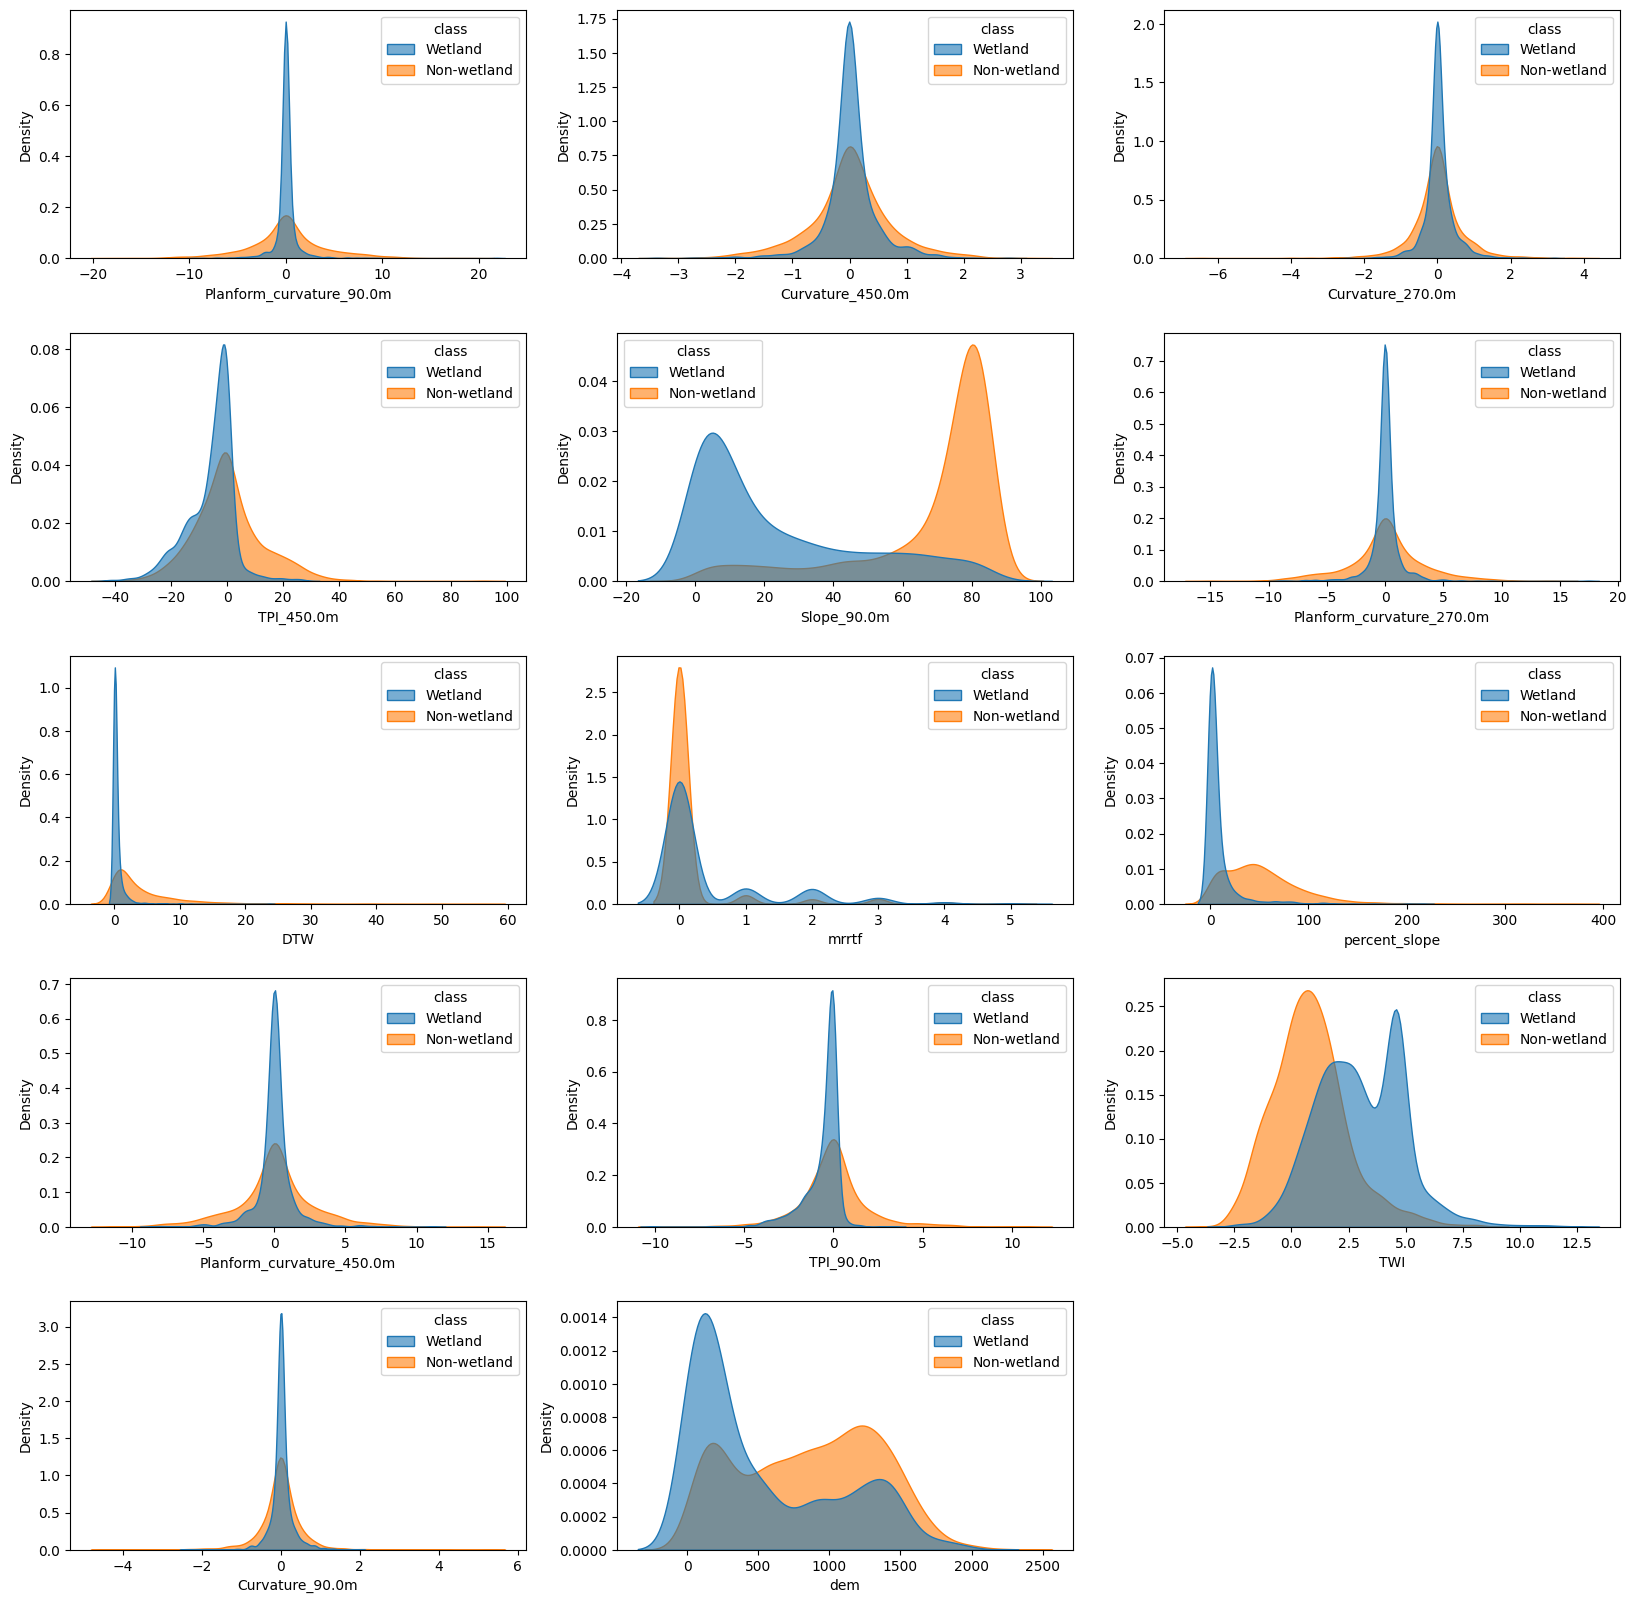

In [32]:
# Ensure only numerical features are selected
X_ = df_training_data.drop(columns=["class_id_type"])
feature_names = X_.select_dtypes(include=["number"]).columns.tolist()[
    1:
]  # Exclude class column

# Create a copy and map class labels
df_training_data_binary = df_training_data.copy()
df_training_data_binary["class"] = df_training_data["class_id_binary"].map(
    {0: "Non-wetland", 1: "Wetland"}
)

# Set up the subplot grid
n_cols = 3
n_rows = -(
    -len(feature_names) // n_cols
)  # Equivalent to math.ceil(len(feature_names) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

# Custom color mapping (Blue for Wetland, Orange for Non-wetland)
custom_palette = ["#1f77b4", "#ff7f0e"]  # Blue, Orange

# Loop through each feature and plot KDE (density) curves
for i, feature in enumerate(feature_names):
    sns.kdeplot(
        data=df_training_data_binary,
        x=feature,
        hue="class",
        hue_order=["Wetland", "Non-wetland"],  # Ensure Wetland is first
        palette=custom_palette,
        common_norm=False,
        ax=axes[i],
        fill=True,
        alpha=0.6,
    )
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Density")

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(hspace=0.3)
plt.show()

#### Multi-Class Random Forest frequency distribution plots

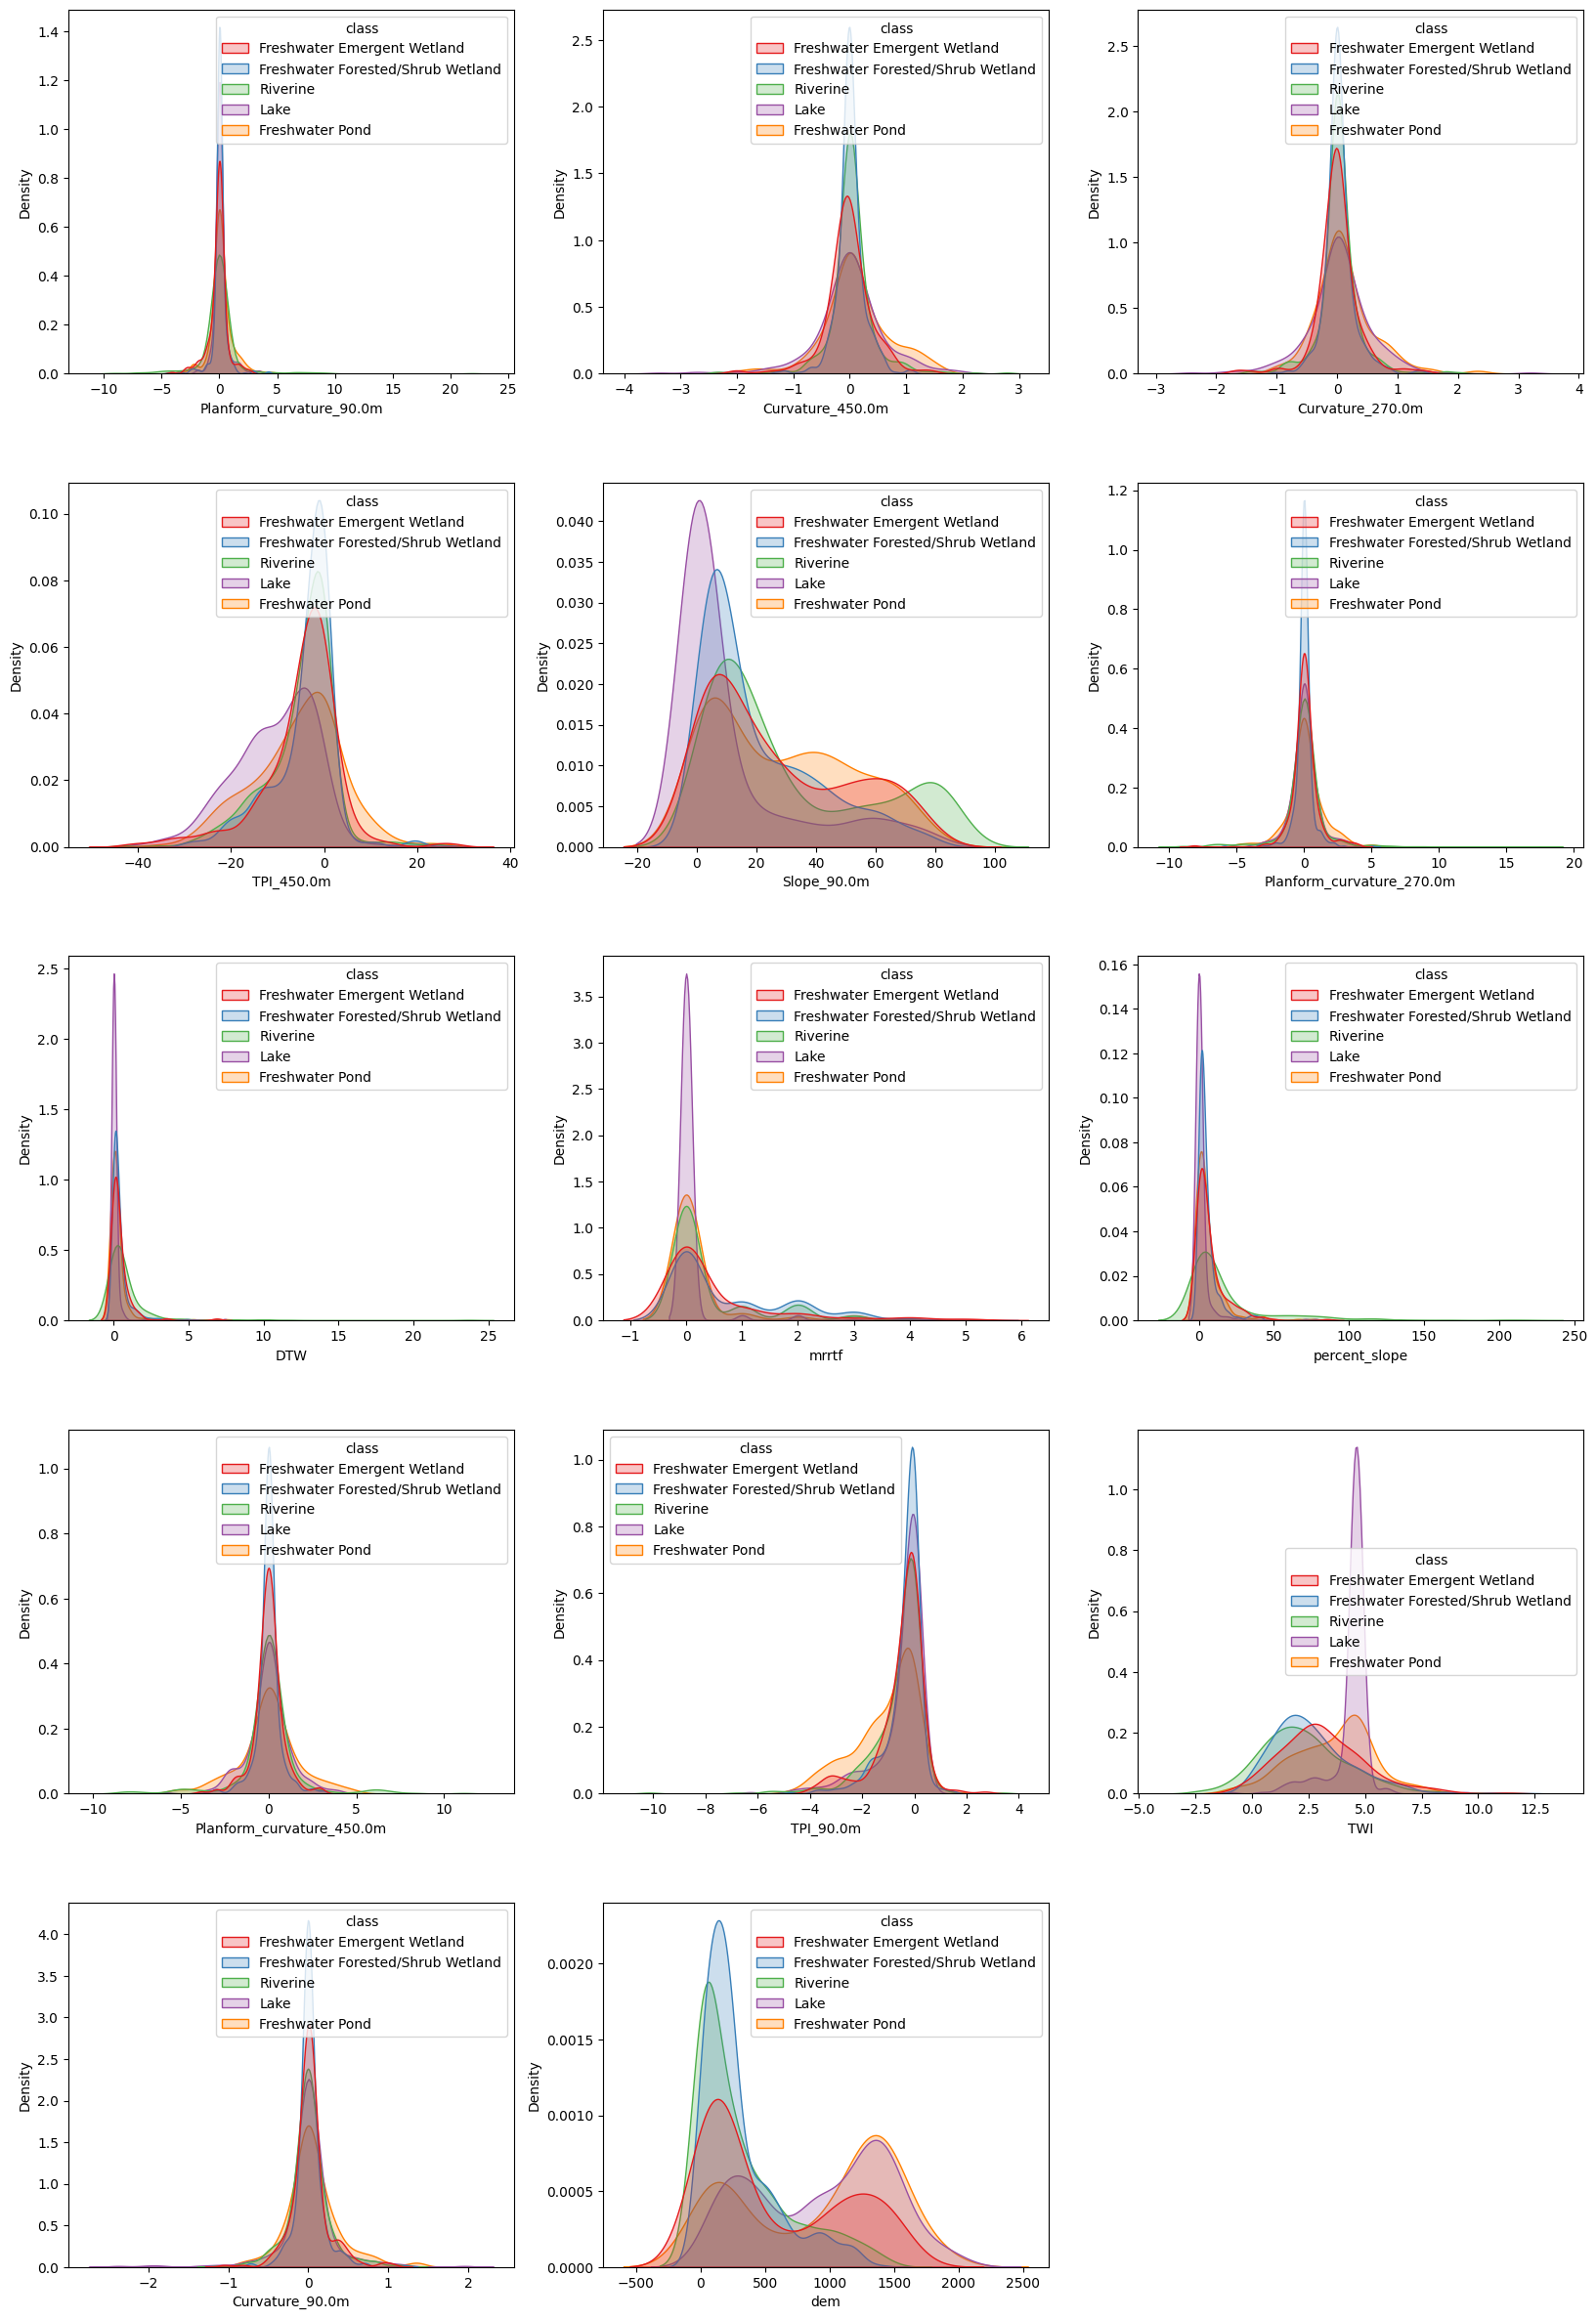

In [33]:
# Exclude rows with the non-wetland class (class_id_type == 0)
df_training_data_filtered = df_training_data[
    df_training_data["class_id_type"] != 0
].copy()

# Select only the relevant features
X_ = df_training_data_filtered.drop(
    ["class_id_binary"], axis=1
)  # Drop irrelevant columns
feature_names = X_.columns[1:].tolist()  # Exclude the class column itself

df_training_data_type = df_training_data_filtered.copy()

# Step 1: Map the `class_id_type` values to their respective class names
df_training_data_type["class"] = df_training_data_type["class_id_type"].map(
    {v: k for k, v in labels_dict_type.items()}
)

# Determine the number of rows and columns for subplots
n_cols = 3
n_rows = (len(feature_names) + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
axes = axes.flatten()

# Define a color palette dynamically based on unique class labels
unique_classes = df_training_data_type["class"].unique()
palette = sns.color_palette("Set1", n_colors=len(unique_classes))

# Loop through each feature and plot KDE (density) curves
for i, feature in enumerate(feature_names):
    sns.kdeplot(
        data=df_training_data_type,
        x=feature,
        hue="class",
        palette=palette,
        common_norm=False,
        ax=axes[i],
        fill=True,
    )
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Density")

# Remove empty subplots (if features < total grid slots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(hspace=0.3)
plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 